<a href="https://colab.research.google.com/github/AishaEvering/Art_Geek/blob/main/Art_Geek.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Art Geek


![header](https://drive.google.com/uc?export=view&id=1yd0E6pXMrN-NWy9wUDhTRFDzaC0g5g3r)

### Project Overview

In this project, I will train neural network models to classify artwork based on a combination of their characteristics. The models will be developed using a diverse dataset from [Hugging Face](https://huggingface.co/datasets/huggan/wikiart), which provides a rich collection of artwork across various categories.

Although the problem has mulitple labels, each label has multiple classes so the problem is a **multi-class classification** problem. Unlike traditional single-class classification, this approach involves predicting multiple aspects of each artwork. Each artwork will be assigned a set of labels, providing a comprehensive understanding of its characteristics.

### Key Objectives

- **Develop and Train Neural Networks**: Fine-tune models to accurately classify artworks into multiple categories.
- **Handle Multi-Class Classification**: Implement techniques for multi-class classification to predict different aspects the artwork simultaneously.
- **Leverage a Diverse Dataset**: Utilize the [WikiArt dataset](https://huggingface.co/datasets/huggan/wikiart) from Hugging Face to ensure a broad and representative range of artwork samples.

### Project Details

1. **Dataset**: The [WikiArt dataset](https://huggingface.co/datasets/huggan/wikiart) from Hugging Face provides a vast collection of artworks categorized by artist, genre, and style.
   
2. **Task**: Develop models to classify artworks into multiple categories, which may or may not include predicting:
   - **Artist**: The creator of the artwork.
   - **Genre**: The genre of the artwork.
   - **Style**: The artistic style used in the artwork.

3. **Approach**:
   - **EDA**: Get to know the data and determine is the task at hand is feasible.
   - **Data Preparation**: Preprocess and augment the dataset to enhance model performance.
   - **Model Training**: Train and optimize neural network models for multi-label classification.
   - **Evaluation**: Assess the model's performance using appropriate multi-label metrics.


## Project Preperation

In [1]:
!pip3 -qqq install datasets
!pip3 -qqq install torchinfo
!pip3 -qqq install tqdm
!pip3 -qqq install kaleido
!pip3 -qqq install pillow torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9

In [2]:
import os
import random
from PIL import Image
import pandas as pd
from pathlib import Path
import torch
import torchvision
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from datasets import load_dataset, Dataset
import matplotlib.pyplot as plt
import plotly.express as px

%matplotlib inline

In [89]:
IMAGE_SIZE = (288, 288)
BATCH_SIZE = 32
SEED = 42
EPOCHS = 20
THRESHOLDS = [0.6, 0.7, 0.8]
BEST_THRESHOLD = 0.7

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# Set seeds
def set_seeds(seed: int=SEED):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

## Load Data

Downloading **100%** of the data. Getting a look at all the data from the start will give me more of an idea on what the models might have more success in predicting.  The initial experiments will be trained on 10% of the data for faster training times.  Once I evaluate the metrics from the baseline and comparison models, I will train the best-performing model on 100% of the data.

In [5]:
ds = load_dataset('huggan/wikiart', split='train')
ds

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Resolving data files:   0%|          | 0/72 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/81444 [00:00<?, ? examples/s]

Loading dataset shards:   0%|          | 0/45 [00:00<?, ?it/s]

Dataset({
    features: ['image', 'artist', 'genre', 'style'],
    num_rows: 81444
})

In [6]:
# create initial annotations dataframe
full_annotations = ds.to_pandas()

full_annotations.drop('image', axis=1, inplace=True)

# add the image names
full_annotations['image_name'] = [f'image_{idx}.jpg' for idx in range(len(full_annotations))]

full_annotations.head()

artist  genre  style   image_name
0      22      4     21  image_0.jpg
1      20      7      4  image_1.jpg
2      16      6     20  image_2.jpg
3      17      2     12  image_3.jpg
4       9     10     23  image_4.jpg

In [7]:
def format_class_name(label:list[str]) -> list[str]:
  """
  Formats and cleans the class names by replacing underscores and hyphens with spaces and capitalizing each word.

  Args:
      labels (list[str]): A list of class name strings to be formatted.

  Returns:
      list[str]: A list of formatted class name strings.
  """
  return [item.replace('_', ' ').replace('-', ' ').title() for item in label]

In [8]:
# format class labels
genres = format_class_name(ds.features['genre'].names)
styles = format_class_name(ds.features['style'].names)
artists = format_class_name(ds.features['artist'].names)

In [9]:
# add artist, genre, and style names
full_annotations['artist_name'] = full_annotations['artist'].map(lambda x: artists[x])
full_annotations['genre_name'] = full_annotations['genre'].map(lambda x: genres[x])
full_annotations['style_name'] = full_annotations['style'].map(lambda x: styles[x])
full_annotations.head()

artist  genre  style   image_name            artist_name  \
0      22      4     21  image_0.jpg       Vincent Van Gogh   
1      20      7      4  image_1.jpg              Rembrandt   
2      16      6     20  image_2.jpg           Paul Cezanne   
3      17      2     12  image_3.jpg  Pierre Auguste Renoir   
4       9     10     23  image_4.jpg        Ivan Aivazovsky   

           genre_name          style_name  
0           Landscape             Realism  
1  Religious Painting             Baroque  
2            Portrait  Post Impressionism  
3      Genre Painting       Impressionism  
4       Unknown Genre         Romanticism

## EDA (Exploratory Data Analysis)


Some of the things I looking for during EDA are...

* Is the data balanced across each label, artist, genre, and style?
* What is the most/least common genre?
* What is the most/least common style?
* Who is the most/least common artist?
  
Understanding these details about the data will provide deeper insights and help set expectations for the performance of the trained models.

In [10]:
plots_dir = Path('plots/')
if not plots_dir.is_dir():
  plots_dir.mkdir(parents=True, exist_ok=True)

In [11]:
def save_plotly_plot(plot_fig, root_dir=plots_dir):
  name = plot_fig.layout.title.text.replace(' ','_').lower() + ".png"

  plot_name = root_dir / name
  plot_fig.write_image(plot_name)
  plot_fig.show()
  return plot_name

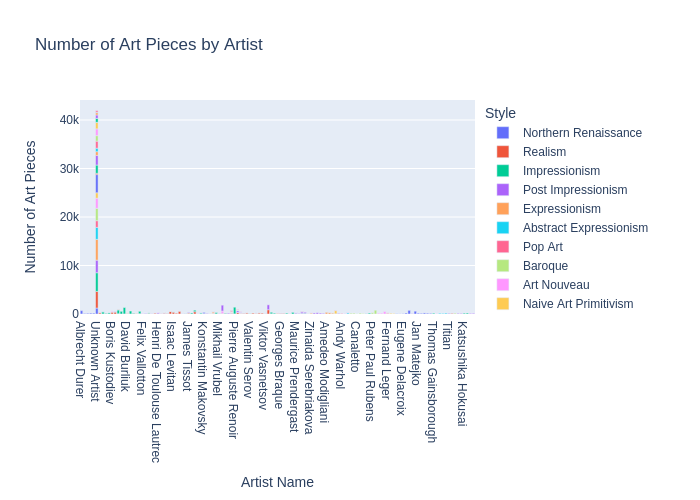

In [12]:
group = full_annotations.groupby(by=['artist_name','style_name']).size().reset_index(name='counts')

fig = px.bar(group, x='artist_name', y='counts', color='style_name',
             labels={'counts':'Number of Art Pieces','artist_name':'Artist Name', 'style_name': 'Style'},
             title="Number of Art Pieces by Artist")

Image.open(save_plotly_plot(fig))

**Insights**

* The data is extremely imbalanced towards unknown artists.

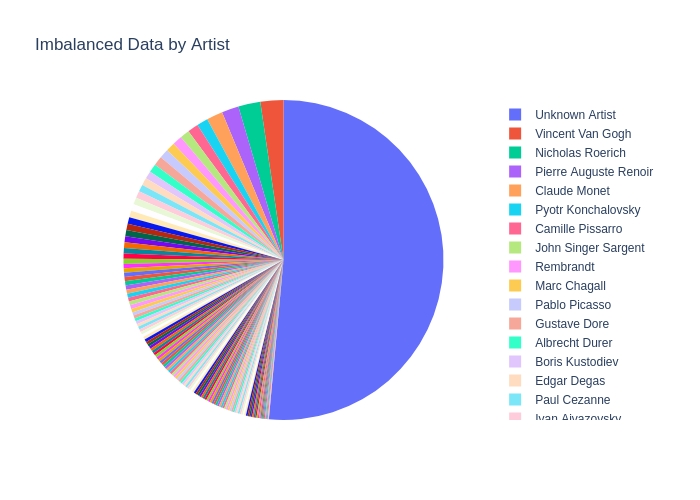

In [13]:
group = full_annotations.groupby(by=['artist_name']).size().reset_index(name='counts')

fig = px.pie(group, values='counts', names='artist_name',title="Imbalanced Data by Artist")
fig.update_traces(hoverinfo='label+percent+name', textinfo='none')

Image.open(save_plotly_plot(fig))

**Insights**

* More than half of the data is from unknown artists.
* There a lot of artist with very little artwork.


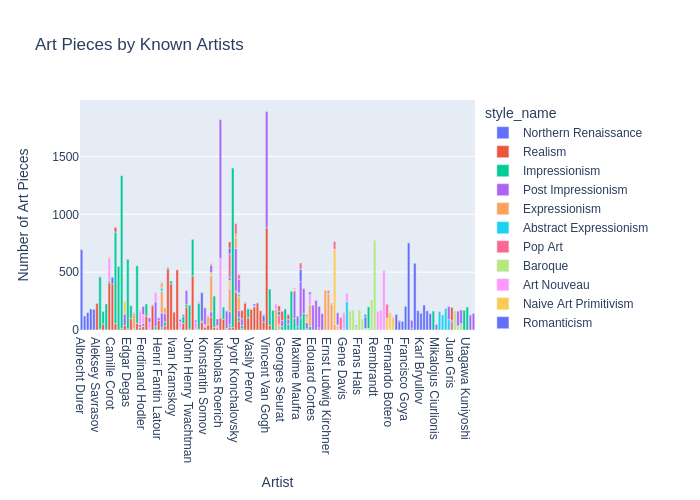

In [14]:
df_known_artist = full_annotations[~full_annotations['artist_name'].isin(['Unknown Artist'])]
known_artist = df_known_artist.groupby(by=['artist_name','style_name']).size().reset_index(name='counts')

fig = px.bar(known_artist, x='artist_name', y='counts', color='style_name',
             labels={'counts':'Number of Art Pieces','artist_name':'Artist'},
             title="Art Pieces by Known Artists")

Image.open(save_plotly_plot(fig))

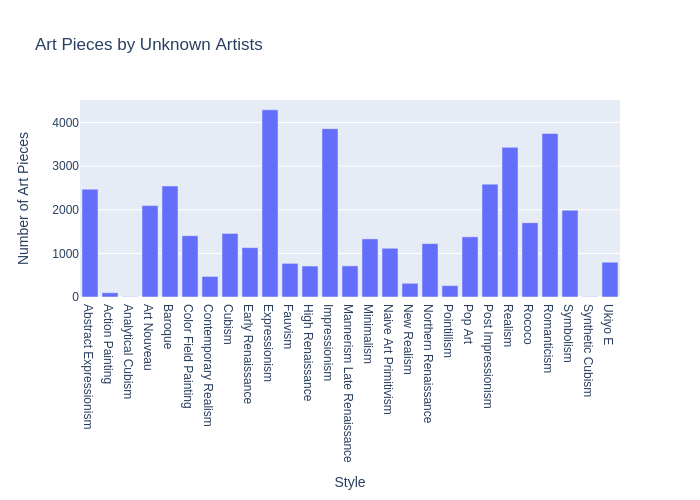

In [15]:
df_unknown_artist = full_annotations[full_annotations['artist_name'].isin(['Unknown Artist'])]
unknown_artist = df_unknown_artist.groupby(by=['artist_name','style_name']).size().reset_index(name='counts')

fig = px.bar(unknown_artist, x='style_name', y='counts',
             labels={'counts':'Number of Art Pieces','style_name':'Style'},
             title="Art Pieces by Unknown Artists")

Image.open(save_plotly_plot(fig))

**Insights**

* The known artist with the most pieces, Vincent Van Gogh, has a maximum of around 2,000 artworks.
*  The top style from an unknown artist exceeds 4,000 pieces.

This significant imbalance will likely affect the model's predictions. To address this, I plan to undersample the artworks from the unknown artist to give the model a better chance of accurately predicting the artist labels.

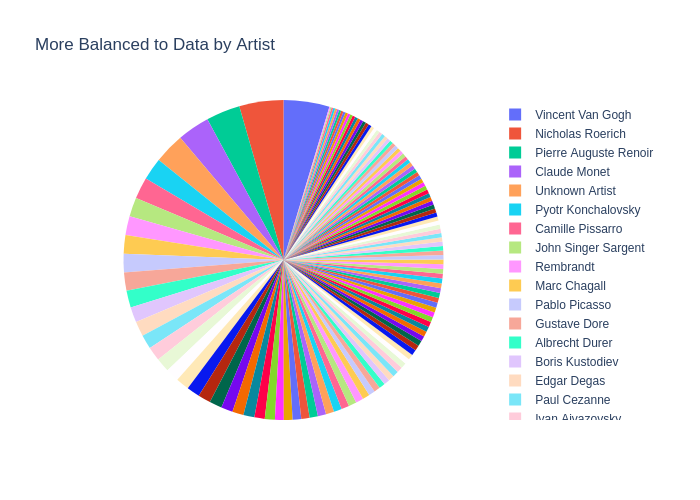

In [16]:
from sklearn.utils import resample

fraction = 0.03

# undersample "Unknown" samples
unknown_artist_undersampled = resample(df_unknown_artist, replace=False,
                                       n_samples=int(len(df_unknown_artist) * fraction),
                                       random_state=42)

full_annotations = pd.concat([df_known_artist, unknown_artist_undersampled])

group = full_annotations.groupby(by=['artist_name']).size().reset_index(name='counts')

fig = px.pie(group, values='counts', names='artist_name',title="More Balanced to Data by Artist")
fig.update_traces(hoverinfo='label+percent+name', textinfo='none')

Image.open(save_plotly_plot(fig))

In [17]:
print(f'annotations shape: {full_annotations.shape}')
full_annotations.head()

annotations shape: (40787, 7)


artist  genre  style   image_name            artist_name  \
0      22      4     21  image_0.jpg       Vincent Van Gogh   
1      20      7      4  image_1.jpg              Rembrandt   
2      16      6     20  image_2.jpg           Paul Cezanne   
3      17      2     12  image_3.jpg  Pierre Auguste Renoir   
4       9     10     23  image_4.jpg        Ivan Aivazovsky   

           genre_name          style_name  
0           Landscape             Realism  
1  Religious Painting             Baroque  
2            Portrait  Post Impressionism  
3      Genre Painting       Impressionism  
4       Unknown Genre         Romanticism

**Insights**

* Despite balancing the data, many artists still have only a small amount of artwork.
*  The models will struggle to accurately predict these artists without significantly more data specific to them.
*  I will be excluding the artist label as a lable for the models to predict.

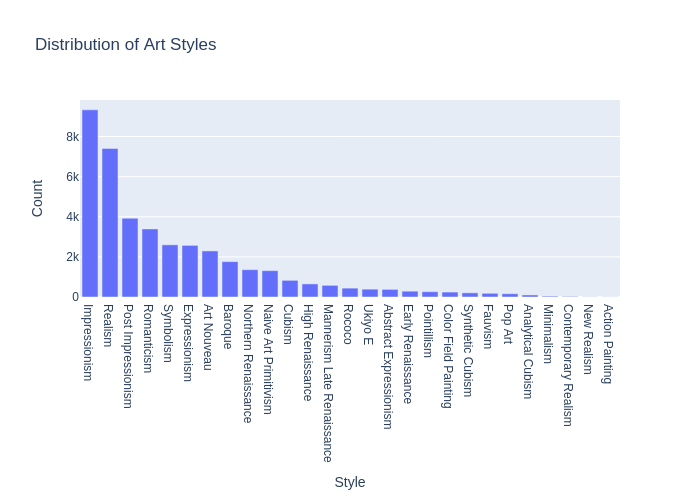

In [18]:
import plotly.graph_objects as go

# Count the occurrences of each style
style_counts = full_annotations['style_name'].value_counts()

# Create a bar chart
fig = go.Figure(data=[go.Bar(x=style_counts.index, y=style_counts.values)])

fig.update_layout(
    title='Distribution of Art Styles',
    xaxis_title='Style',
    yaxis_title='Count'
)

Image.open(save_plotly_plot(fig))

**Insights**

* The top three styles are Impressionism, Realism, and Post-Impressionism.
* There are over 13,000 artworks in the Impressionism style, compared to only 98 in Action Painting.
* Styles like Contemporary Realism, New Realism, and Action Painting may be more challenging for the model to predict.
* There is a noticeable bias towards the top styles. To address this, I will adjust the class weights during training.

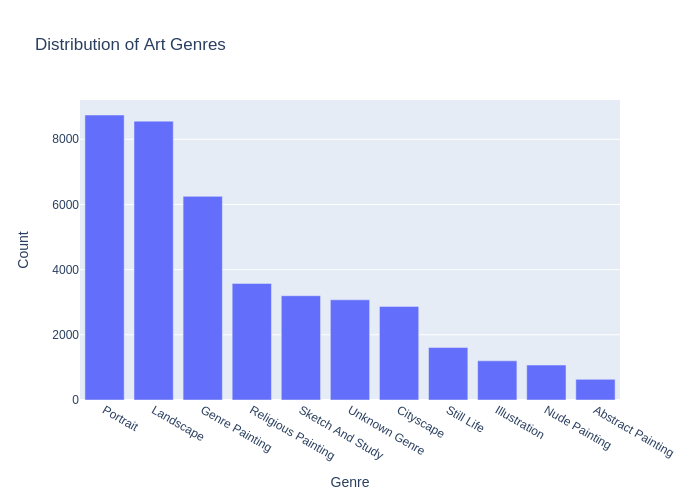

In [19]:
# Count the occurrences of each genre
genre_counts = full_annotations['genre_name'].value_counts()

# Create a bar chart
fig = go.Figure(data=[go.Bar(x=genre_counts.index, y=genre_counts.values)])

fig.update_layout(
    title='Distribution of Art Genres',
    xaxis_title='Genre',
    yaxis_title='Count'
)

Image.open(save_plotly_plot(fig))

**Insights**

* Most of the genres are unknown.
* There are over 16,000 unknown genres compared to the ~2000 Illustration gneres.
* The top genres that are known are Portrait, Landscape, and Genre Painting.
* There is a noticeable bias towards the top genres. To address this, I will adjust the class weights during training.

## Preprocess Data

### Filter Data


In [20]:
# train_test_split breaks for combinations < 2, filtering out those groups for now.

def filter_out_low_value_combos(df, group):
  # calculate value counts for each group (artist, genre, style)
  group_counts = df.groupby(group).size()

  # filter out groups with less than 2 instances
  valid_groups = group_counts[group_counts >= 2].index

  # filter annotations DataFrame based on valid groups
  df_filtered = df[
      df[group].apply(tuple, axis=1).isin(valid_groups)
  ]
  return df_filtered

### Get 10% of Data

In [21]:
label_group = ['genre', 'style']

full_annotations_filtered = filter_out_low_value_combos(full_annotations, label_group)[['image_name', 'genre','style']].copy()

# getting 10% of the data for the initial runs
_, annotations_10pt = train_test_split(full_annotations_filtered, test_size=0.1, stratify=full_annotations_filtered[label_group])
annotations_10pt.shape

(4078, 3)

In [22]:
annotations_10pt.head()

image_name  genre  style
26527  image_26527.jpg      7      9
40838  image_40838.jpg      6     12
65044  image_65044.jpg      6     23
62208  image_62208.jpg      8     23
7445    image_7445.jpg      6     12

### Split Data

In [23]:
annotations_10pt_filtered = filter_out_low_value_combos(annotations_10pt, label_group).copy()

# split dataset into train and temp sets
train_annotations_10pt, temp_annotations = train_test_split(
    annotations_10pt_filtered, test_size=0.4, stratify=annotations_10pt_filtered[label_group]
)

# split temp set into validation and test sets
val_annotations_10pt, test_annotations_10pt = train_test_split(temp_annotations, test_size=0.2)

train_annotations_10pt.shape, val_annotations_10pt.shape, test_annotations_10pt.shape

((2425, 3), (1294, 3), (324, 3))

In [24]:
train_annotations_10pt.head()

image_name  genre  style
53187  image_53187.jpg      2     21
4829    image_4829.jpg      2     12
20882  image_20882.jpg      6     20
41109  image_41109.jpg      1      9
24826  image_24826.jpg      2     24

### Encode Labels

In [25]:
# define unique classes for each label
unique_genres = annotations_10pt['genre'].unique().tolist()
unique_styles = annotations_10pt['style'].unique().tolist()

# Multi-label binarizer
mlb_genre = MultiLabelBinarizer(classes=unique_genres)
mlb_style = MultiLabelBinarizer(classes=unique_styles)

# fit and transform training data
train_annotations_10pt['genre'] = mlb_genre.fit_transform(train_annotations_10pt[['genre']].values).tolist()
train_annotations_10pt['style'] = mlb_style.fit_transform(train_annotations_10pt[['style']].values).tolist()
train_annotations_10pt.head()

image_name                              genre  \
53187  image_53187.jpg  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]   
4829    image_4829.jpg  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]   
20882  image_20882.jpg  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
41109  image_41109.jpg  [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]   
24826  image_24826.jpg  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]   

                                                   style  
53187  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4829   [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
20882  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
41109  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
24826  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

In [26]:
# transform validation
val_annotations_10pt['genre'] = mlb_genre.transform(val_annotations_10pt[['genre']].values).tolist()
val_annotations_10pt['style'] = mlb_style.transform(val_annotations_10pt[['style']].values).tolist()
val_annotations_10pt.head()

image_name                              genre  \
7222    image_7222.jpg  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]   
17358  image_17358.jpg  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]   
5503    image_5503.jpg  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
9404    image_9404.jpg  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]   
14817  image_14817.jpg  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]   

                                                   style  
7222   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...  
17358  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
5503   [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...  
9404   [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
14817  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

In [27]:
# transform test
test_annotations_10pt['genre'] = mlb_genre.transform(test_annotations_10pt[['genre']].values).tolist()
test_annotations_10pt['style'] = mlb_style.transform(test_annotations_10pt[['style']].values).tolist()
test_annotations_10pt.head()

image_name                              genre  \
2090    image_2090.jpg  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]   
25483  image_25483.jpg  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]   
48548  image_48548.jpg  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
33985  image_33985.jpg  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]   
30649  image_30649.jpg  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]   

                                                   style  
2090   [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
25483  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
48548  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
33985  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
30649  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

## Download Annotations & Images

Saving annotations and images to their appropriate directory to make them easier to work with.  I will be following this....


```
data/
  ├── 10
  │ ├── train/
  │ │   ├── images/
  │ │   └── train_annotations.csv
  │ ├── validation/
  │ │   ├── images/
  │ │   └── val_annotations.csv
  │ ├── test/
  │ │   ├── images/
  │ │   └── test_annotations.csv
  │ └── modules/
  ├── Full

```



In [28]:
#!rm -fr '/content/data/10/'

In [29]:
from pathlib import Path

def make_dirs(path, dirs: list[str]) -> None:
    """
    Create directories for data storage if they do not exist.

    Parameters:
    path (str): Base path where the directories will be created.
    dirs (list[str]): List of children directory names.

    Returns:
    None
    """
    path = Path(path)

    for d in dirs:
        dir_path = path / d
        if not dir_path.is_dir():
            dir_path.mkdir(parents=True, exist_ok=True)


In [30]:
root = 'data/10/'
child_dirs = ['train', 'val', 'test']

# make all the directories for the data
make_dirs(root, child_dirs)

data_path = Path(root)
train_dir = data_path / child_dirs[0]
val_dir = data_path / child_dirs[1]
test_dir = data_path / child_dirs[2]

# save split annotations
train_annotations_10pt.to_csv(train_dir / 'train_annotations.csv', index=False)
val_annotations_10pt.to_csv(val_dir / 'val_annotations.csv', index=False)
test_annotations_10pt.to_csv(test_dir / 'test_annotations.csv', index=False)

In [31]:
def save_image(image: Image.Image, filename: str, image_size: tuple[int, int] = IMAGE_SIZE) -> None:
    """
    Save an image to the specified directory after resizing it.

    Args:
        image (Image.Image): The image to be saved.
        filename (str): The name to save the image file as.
        image_size (tuple[int, int], optional): The desired size to resize the image to. Defaults to (288, 288).
    """

    # resize the image
    image_resized = image.resize(image_size, Image.LANCZOS)

    # save the resized image to the specified path
    image_resized.save(filename)

In [32]:
import re

def download_images(root:Path, child_dirs:Path, dataset:Dataset, annotation_dataframes:list[pd.DataFrame]) -> None:
  """
  Downloading all the images to their respective directories.

  Args:
    root(Path): root path
    child_dirs(Path): names of directories that match the data split
    dataset(Dataset): dataset that contains the images
    annotation_dataframes(list[pd.DataFrame]): list of dataframes that contain the details about the image files
  """
  pattern = r'_(\d+)\.jpg'

  for split, annotations in zip(child_dirs, annotation_dataframes):

      images_path = root / split / 'images'

      # make images directory
      if images_path.is_dir():
        print(f'{images_path} directory already exists...skipping download')
        continue
      else:
        images_path.mkdir(parents=True, exist_ok=True)

      # process and save images
      for idx, row in tqdm(annotations.iterrows(), total=len(annotations), desc=f'Downloading {split} images...'):

        # get file name out of annotation
        name = annotations.loc[idx]['image_name']

        # get index out of file name
        image_id = int(re.search(pattern, name).group(1))

        # use index to get image out of dataset
        image_item = dataset[image_id]['image']

        # save image
        save_image(image = image_item, filename = images_path / row['image_name'])

In [33]:
# download images to disk
download_images(data_path, child_dirs, dataset=ds,
                annotation_dataframes = [train_annotations_10pt, val_annotations_10pt, test_annotations_10pt])

## Visualize Data

In [34]:
import matplotlib.pyplot as plt
import random
import numpy as np

def visualize_data(image_path, annotations:pd.DataFrame,
                   genres:list[str], styles:list[str],
                   artwork_count:int=8) -> None:

  UKNOWN_VALUE = '<not found>'
  cols = 4
  rows = artwork_count // cols

  # set up the plot
  plt.figure(figsize=(12, 4 * rows))

  # get all the image paths
  img_path_list = list(image_path.glob('*/*.jpg'))

  for i in range(rows * cols):
      # pick a random image path
      random_img_path = random.sample(img_path_list, k=1)[0]

      # get the corresponding sample data
      sample_data = annotations[annotations['image_name'] == random_img_path.name]

      # extract encoded labels from the sample
      genre_labels = np.array(sample_data['genre'].tolist())
      style_labels = np.array(sample_data['style'].tolist())

      # decode the labels
      decoded_genres = mlb_genre.inverse_transform(genre_labels)
      decoded_styles = mlb_style.inverse_transform(style_labels)

      # get the genre, and style for the current sample
      genre = genres[decoded_genres[0][0]] if decoded_genres[0] else UKNOWN_VALUE
      style = styles[decoded_styles[0][0]] if decoded_styles[0] else UKNOWN_VALUE

      # plot the image
      ax = plt.subplot(rows, cols, i + 1)
      plt.imshow(Image.open(random_img_path))
      plt.title(f"Genre: {genre}\nStyle: {style}", size=10)
      plt.axis('off')

  # show the plot
  plt.tight_layout()
  plt.show()


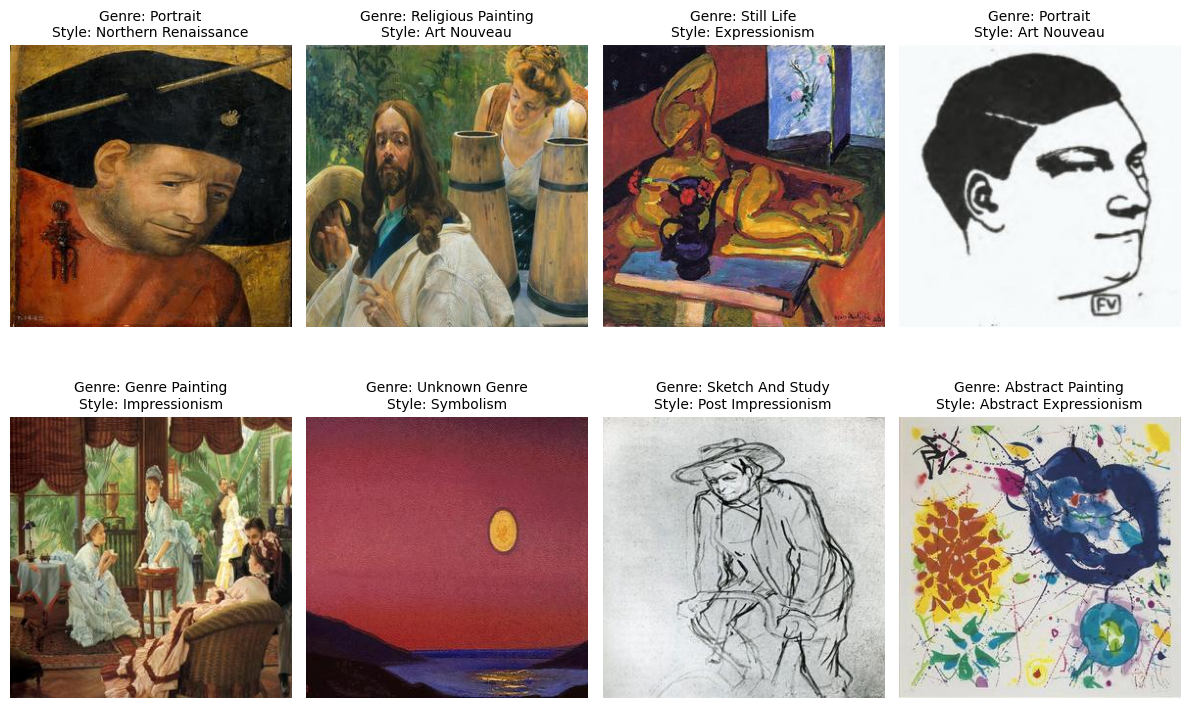

In [35]:
# take a look at the training images
visualize_data(image_path=train_dir,
               annotations=train_annotations_10pt,
               genres=genres, styles=styles)

##Experiment

###Objective

The goal is to train and compare two feature extractors on the images to determine the best-performing model for our task.

*Feature Extractor?*

>A feature extractor is a model used in transfer learning where the base layers are frozen, and the output (or head) layers are customized to address a specific problem. This approach leverages pre-trained models to extract relevant features from the data, reducing training time and improving performance.
<br/><br/>
###Plan

**Baseline Model: EfficientNet-B2 (EffNetB2)**

Choice Rationale:

EfficientNet-B2 is known for its excellent performance and efficiency. It provides a strong starting point due to its balance between accuracy and computational resource requirements.

Approach:

Train the EfficientNet-B2 model with frozen base layers and customized output layers tailored to multi-label classification problem.

<br/>

**Comparison Model: Vision Transformer (ViT)**

Choice Rationale:

Transformers have shown superior performance over traditional Convolutional Neural Networks (CNNs) in various tasks. The Vision Transformer (ViT) represents a modern approach that could potentially yield better results.

Approach:

Train the Vision Transformer with frozen base layers and customized output layers, similar to the baseline model, and compare its performance against EfficientNet-B2.

<br/>


###Data Augmentation:

To enhance the robustness and performance of the models, I will apply additional data augmentation techniques. Augmentation can help improve model generalization by creating variations of the training data, leading to potentially better metrics.

###In General:

* Class weights will be adjusted to give more importance to less frequent classes.
* Epochs: 20
* Loss Function: nn.CrossEntropyLoss()
  * good for selecting between multiple classes
* Optimizer = AdamW
  >Adapts the learning rate for each parameter based on estimates of first and second moments of the gradients. This can lead to more stable and efficient training, particularly beneficial in multi-label classification where different labels might have different characteristics.
* Learning Rate: 0.0004
* Weight Decay (L2 regularization) = 1e-5
  * Helps in preventing overfitting

### Experiment 1 (EffNetB2)

In [36]:
# setup pretrained EffNetB2 weights
effnet_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

# get EffNetB2 transforms
effnetb2_transforms = effnet_weights.transforms()

# init pretrained model
effnetb2 = torchvision.models.efficientnet_b2(weights=effnet_weights)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:01<00:00, 25.5MB/s]


In [37]:
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [38]:
from torchinfo import summary

# Print EffNetB2 summary
summary(effnetb2,
        input_size=(1, 3, 288, 288),
        col_names=['input_size','output_size','num_params','trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 288, 288]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 288, 288]     [1, 1408, 9, 9]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 288, 288]     [1, 32, 144, 144]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 288, 288]     [1, 32, 144, 144]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 144, 144]    [1, 32, 144, 144]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 144, 144]    [1, 32, 144, 144]    --                   --
│    └─Sequential (1)                                        [1, 32, 144, 144]    [1, 16, 144,

There are > 9_000_000 trainable parameters.

**Plan**
* Freeze all the trainable layers except for the classifier output layer.
* Add a Sigmoid layer to the output layer since the problem involves multiple classifications.



In [39]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

#### Create Model

In [40]:
#%%writefile modules/create_effnetb2_model.py
"""Contains function for creating an effnetb2 model with a sigmoid layer added to the output to handle multi-labeled classification.
"""
from torch import nn
import torch
import torchvision
from torchvision import transforms

def create_effnetb2_model(num_classes=10, seed=42) -> tuple[torchvision.models.EfficientNet, torchvision.transforms.Compose]:
    """
    Creates an EfficientNet-B2 model with a custom classifier head and specified transformations.

    Parameters:
    num_classes (int): The number of output classes.
    seed (int): Random seed for reproducibility.

    Returns:
    tuple: A tuple containing the EfficientNet-B2 model and the transformations used.
    """

    # Load pre-trained EfficientNet-B2 weights
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Freeze base layers in the model (this will stop all layers from training)
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes, bias=True),
        nn.Sigmoid()
    )

    return model, transforms


In [65]:
num_classes = len(unique_genres) + len(unique_styles)

base_effnetb2, base_effnetb2_transforms = create_effnetb2_model(num_classes=num_classes)

In [66]:
# Print base EffNetB2 summary
summary(base_effnetb2,
        input_size=(1, 3, 288, 288),
        col_names=['input_size','output_size','num_params','trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 288, 288]     [1, 37]              --                   Partial
├─Sequential (features)                                      [1, 3, 288, 288]     [1, 1408, 9, 9]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 288, 288]     [1, 32, 144, 144]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 288, 288]     [1, 32, 144, 144]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 144, 144]    [1, 32, 144, 144]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 144, 144]    [1, 32, 144, 144]    --                   --
│    └─Sequential (1)                                        [1, 32, 144, 144]    [1, 1

**Good to be Frozen:**

Trainable params dropped from 9,109,994 -> 235,303.  Yay! transfer learning.  It's cool right?

#### Create Dataloaders

In [67]:
#%%writefile modules/data_setup.py
"""Contains function for creating dataloaders using annotation files.
"""
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file: str, root_dir: str, transform=None):
        """
        Initializes the dataset.

        Args:
        annotations_file (str): Path to the CSV file containing image file names and labels.
        root_dir (str): Directory containing all the images.
        transform (callable, optional): Transformations to apply to the images.
        """
        self.annotations = pd.read_csv(annotations_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = os.path.join(self.root_dir, self.annotations.iloc[idx, 0])
        image = Image.open(img_path)

        # extract labels
        genre_labels = self.annotations.iloc[idx, 1]
        style_labels = self.annotations.iloc[idx, 2]

        # Convert labels to lists/arrays
        genre_labels = np.array(eval(genre_labels))
        style_labels = np.array(eval(style_labels))

        # Convert to PyTorch tensors
        genre_labels = torch.tensor(genre_labels, dtype=torch.float)
        style_labels = torch.tensor(style_labels, dtype=torch.float)

        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)

        return image, genre_labels, style_labels

def data_setup(train_transform,
               test_transform,
               train_annotations:str,
               val_annotations:str,
               test_annotations:str,
               train_images:str,
               val_images:str,
               test_images:str,
               num_workers:int,
               batch_size:int = BATCH_SIZE):

  # create datasets
  train_dataset = CustomImageDataset(annotations_file=train_annotations, root_dir=train_images, transform=train_transform)
  val_dataset = CustomImageDataset(annotations_file=val_annotations, root_dir=val_images, transform=test_transform)
  test_dataset = CustomImageDataset(annotations_file=test_annotations, root_dir=test_images, transform=test_transform)

  # create dataloaders
  train_dataloader = DataLoader(dataset=train_dataset,
                                batch_size=batch_size, # how many samples per batch?
                                num_workers=num_workers, # how many subprocesses to use for data loading? (higher = more)
                                shuffle=True,
                                pin_memory=True) # faster transfer to GPU memory

  val_dataloader = DataLoader(dataset=val_dataset,
                              batch_size=batch_size,
                              num_workers=num_workers,
                              shuffle=False, # no shuffling on val/test
                              pin_memory=True)

  test_dataloader = DataLoader(dataset=test_dataset,
                              batch_size=batch_size,
                              num_workers=num_workers,
                              shuffle=False, # no shuffling on val/test
                              pin_memory=True)

  return train_dataloader, val_dataloader, test_dataloader

In [69]:
# Paths to the annotation files and image directory
train_annotations_path = train_dir / 'train_annotations.csv'
val_annotations_path = val_dir / 'val_annotations.csv'
test_annotations_path = test_dir / 'test_annotations.csv'

train_images_path = train_dir / 'images'
val_images_path = val_dir / 'images'
test_images_path = test_dir / 'images'


NUM_WORKERS = os.cpu_count()

train_dataloader, val_dataloader, test_dataloader= data_setup(train_transform=base_effnetb2_transforms,
                                                                          test_transform=base_effnetb2_transforms,
                                                                          train_annotations=train_annotations_path,
                                                                          val_annotations=val_annotations_path,
                                                                          test_annotations=test_annotations_path,
                                                                          train_images=train_images_path,
                                                                          val_images=val_images_path,
                                                                          test_images=test_images_path,
                                                                          num_workers=NUM_WORKERS,
                                                                          batch_size=BATCH_SIZE)

#### Train Model

In [70]:
import torch
from torch import nn
import torch.optim as optim
import numpy as np
from tqdm.auto import tqdm

def train_step(model: nn.Module,
               dataloader: torch.utils.data.DataLoader,
               genre_loss_fn: nn.Module,
               style_loss_fn: nn.Module,
               optimizer: optim.Optimizer,
               device: torch.device,
               epoch: int,
               num_epochs: int,
               num_genres: int) -> tuple:
    """
    Trains a PyTorch model for a single epoch.

    Args:
    model (nn.Module): A PyTorch model to be trained.
    dataloader (torch.utils.data.DataLoader): A DataLoader instance for the model to be trained on.
    genre_loss_fn (nn.Module): A PyTorch loss function to minimize.
    style_loss_fn (nn.Module): A PyTorch loss function to minimize.
    optimizer (optim.Optimizer): A PyTorch optimizer to help minimize the loss function.
    device (torch.device): A target device to compute on (e.g., "cuda" or "cpu").
    epoch (int): The current epoch number, for logging.
    num_epochs (int): The total number of epochs, for logging.
    num_genres (int): Number of unique genres

    Returns:
    dict: (loss, genre_predictions, style_predictions, genre_labels, style_labels)
    """

    # put model in train mode
    model.train()

    # initialize loss metrics
    epoch_loss = 0.0

    num_batches = len(dataloader)

    epoch_genre_predictions = []
    epoch_style_predictions = []

    epoch_genre_labels = []
    epoch_style_labels = []

    for batch_idx, (images, genres, styles) in enumerate(dataloader):
        # send data to device
        images, genres, styles = images.to(device), genres.to(device), styles.to(device)

        # forward pass
        y_pred_logits = model(images)
        genre_logits = y_pred_logits[:, :num_genres]
        style_logits = y_pred_logits[:, num_genres:]

        # calculate loss
        genre_loss = genre_loss_fn(genre_logits, genres)
        style_loss = style_loss_fn(style_logits, styles)
        total_loss = genre_loss + style_loss

        # backward pass and optimization
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # using sigmoid because we need predictions for multiple labels
        genre_preds = torch.sigmoid(genre_logits).detach().cpu().numpy()
        style_preds = torch.sigmoid(style_logits).detach().cpu().numpy()

        # ground truth labels
        genres_np = genres.detach().cpu().numpy()
        styles_np = styles.detach().cpu().numpy()

        epoch_genre_predictions.extend(genre_preds)
        epoch_style_predictions.extend(style_preds)

        epoch_genre_labels.extend(genres_np)
        epoch_style_labels.extend(styles_np)

        # accumulate the total loss
        epoch_loss += total_loss.item()

    # predictions
    genre_predictions = np.array(epoch_genre_predictions)
    style_predictions = np.array(epoch_style_predictions)

    # ground truths
    genre_labels = np.array(epoch_genre_labels)
    style_labels = np.array(epoch_style_labels)

    # average loss over the epoch
    train_loss = epoch_loss / num_batches

    results =  {
        'loss':train_loss,
        'genre_predictions': genre_predictions,
        'style_predictions':style_predictions,
        'genre_labels':genre_labels,
        'style_labels':style_labels
    }

    return results

In [71]:
def validation_step(model: nn.Module,
                    dataloader: torch.utils.data.DataLoader,
                    genre_loss_fn: nn.Module,
                    style_loss_fn: nn.Module,
                    #scheduler: optim.lr_scheduler,
                    device: torch.device,
                    epoch: int,
                    num_epochs: int,
                    num_genres: int) -> tuple:
  """
    Validates a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model (nn.Module): A PyTorch model to be tested.
    dataloader (torch.utils.data.DataLoader): A DataLoader instance for the model to be tested on.
    genre_loss_fn (nn.Module): A PyTorch loss function to minimize.
    style_loss_fn (nn.Module): A PyTorch loss function to minimize.
    scheduler (optim.lr_scheduler): Learning rate scheduler
    device (torch.device): A target device to compute on (e.g., "cuda" or "cpu").
    epoch (int): The current epoch number, for logging.
    num_epochs (int): The total number of epochs, for logging
    num_genres (int): Number of unique genres

    Returns:
    dict: (loss, genre_predictions, style_predictions, genre_labels, style_labels)
  """

  # Put model in eval mode
  model.eval()

  # initialize metrics
  epoch_loss = 0.0

  num_batches = len(dataloader)

  epoch_genre_predictions = []
  epoch_style_predictions = []

  epoch_genre_labels = []
  epoch_style_labels = []

  # Turn on inference context manager
  with torch.inference_mode():
      for batch_idx, (images, genres, styles) in enumerate(dataloader):
        # send data to device
        images, genres, styles = images.to(device), genres.to(device), styles.to(device)

        # forward pass
        y_pred_logits = model(images)
        genre_logits = y_pred_logits[:, :num_genres]
        style_logits = y_pred_logits[:, num_genres:]

        # calculate loss
        genre_loss = genre_loss_fn(genre_logits, genres)
        style_loss = style_loss_fn(style_logits, styles)
        total_loss = genre_loss + style_loss

        # accumulate loss
        epoch_loss += total_loss.item()

        # using sigmoid because we need predictions for multiple labels
        genre_preds = torch.sigmoid(genre_logits).detach().cpu().numpy()
        style_preds = torch.sigmoid(style_logits).detach().cpu().numpy()

        # ground truth labels
        genres_np = genres.detach().cpu().numpy()
        styles_np = styles.detach().cpu().numpy()

        epoch_genre_predictions.extend(genre_preds)
        epoch_style_predictions.extend(style_preds)

        epoch_genre_labels.extend(genres_np)
        epoch_style_labels.extend(styles_np)

      # predictions
      genre_predictions = np.array(epoch_genre_predictions)
      style_predictions = np.array(epoch_style_predictions)

      # ground truths
      genre_labels = np.array(epoch_genre_labels)
      style_labels = np.array(epoch_style_labels)

      # average loss over the epoch
      val_loss = epoch_loss / num_batches

  results = {
      'loss':val_loss,
      'genre_predictions':genre_predictions,
      'style_predictions':style_predictions,
      'genre_labels':genre_labels,
      'style_labels':style_labels
  }

  return  results

In [72]:
def train(model: nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          validation_dataloader: torch.utils.data.DataLoader,
          optimizer: optim.Optimizer,
          genre_loss_fn: nn.Module,
          style_loss_fn: nn.Module,
          epochs: int,
          num_genres: int,
          device: torch.device) -> dict[str, list[float]]:

    """Trains and validates a PyTorch model.

    Passes a target PyTorch model through train_step() and validation_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
      model (nn.Module): A PyTorch model to be trained and tested.
      train_dataloader (torch.utils.data.DataLoader): A DataLoader instance for the model to be trained on.
      validation_dataloader (torch.utils.data.DataLoader): A DataLoader instance for the model to be tested on.
      optimizer (optim.Optimizer): A PyTorch optimizer to help minimize the loss function.
      genre_loss_fn (nn.Module): PyTorch loss function to calculate loss on both datasets.
      style_loss_fn (nn.Module): PyTorch loss function to calculate loss on both datasets.
      epochs (int): An integer indicating how many epochs to train for.
      num_genres (int): Number of unique genres
      device (torch.device): A target device to compute on (e.g., "cuda" or "cpu").

    Returns:
      dict: A dictionary of loss, predictions, ground truth labels, and accuracies by threshold for each step.
    """
    # Create empty results dictionary
    results = {
          "train_loss": [],
          "train_genre_predictions": [],
          "train_style_predictions": [],
          "train_genre_labels": [],
          "train_style_labels": [],
          "validation_loss": [],
          "validation_genre_predictions": [],
          "validation_style_predictions": [],
          "validation_genre_labels": [],
          "validation_style_labels": []
      }

    # loop through training and validation steps for a number of epochs
    for epoch in tqdm(range(epochs), total=epochs, desc=f'Training epoch...'):
        train_results = train_step(model=model,
                                  dataloader=train_dataloader,
                                  genre_loss_fn=genre_loss_fn,
                                  style_loss_fn=style_loss_fn,
                                  optimizer=optimizer,
                                  device=device,
                                  epoch=epoch+1,
                                  num_genres=num_genres,
                                  num_epochs=epochs)



        val_results = validation_step(model=model,
                                     dataloader=validation_dataloader,
                                     genre_loss_fn=genre_loss_fn,
                                     style_loss_fn=style_loss_fn,
                                     device=device,
                                     num_genres=num_genres,
                                     epoch=epoch+1,
                                     num_epochs=epochs)

        print(f"Epoch: {epoch+1}",
            f"train_loss: {train_results['loss']:.4f}",
            f"validation_loss: {val_results['loss']:.4f}",
            sep=" | "
        )

        # Update results dictionary
        results["train_loss"].append(train_results['loss'])
        results["train_genre_predictions"].append(train_results['genre_predictions'])
        results["train_style_predictions"].append(train_results['style_predictions'])
        results["train_genre_labels"].append(train_results['genre_labels'])
        results["train_style_labels"].append(train_results['style_labels'])

        results["validation_loss"].append(val_results['loss'])
        results["validation_genre_predictions"].append(val_results['genre_predictions'])
        results["validation_style_predictions"].append(val_results['style_predictions'])
        results["validation_genre_labels"].append(val_results['genre_labels'])
        results["validation_style_labels"].append(val_results['style_labels'])

    return results


In [73]:
import time
from contextlib import contextmanager

@contextmanager
def track_time():
  start = time.time()
  yield
  end = time.time()
  print(f"Execution time: {end - start:.2f}s")

In [74]:
import numpy as np
import torch

def compute_class_weights(labels, num_classes):
    """
    Compute class weights for multi-label classification.

    Args:
    labels (list[np.ndarray]): List of binary label arrays.
    num_classes (int): Number of classes in the multi-label classification.

    Returns:
    torch.Tensor: Tensor containing the class weights.
    """
    # Count occurrences of each class
    class_counts = np.sum(labels, axis=0)

    # Compute the weights: inverse of class frequencies
    weights = np.ones(num_classes) / (class_counts + 1e-8)  # Adding a small value to avoid division by zero

    # Convert to tensor
    return torch.tensor(weights, dtype=torch.float32)


In [75]:
def get_genre_and_style_weights(dataloader, num_genre_classes, num_style_classes):
    """
    Collect labels and compute class weights for artist, genres and styles.

    Args:
    dataloader (torch.utils.data.DataLoader): DataLoader for the dataset.
    num_genre_classes (int): Number of genre classes.
    num_style_classes (int): Number of style classes.

    Returns:
    tuple: (genre_weights, style_weights)
    """
    # Collect all labels from the dataset
    all_genre_labels = []
    all_style_labels = []

    for _, genres, styles in dataloader:
      all_genre_labels.extend(genres.numpy().reshape(-1))
      all_style_labels.extend(styles.numpy().reshape(-1))

    # Compute class weights
    genre_weights = compute_class_weights(all_genre_labels, num_genre_classes)
    style_weights = compute_class_weights(all_style_labels, num_style_classes)

    return genre_weights.to(device), style_weights.to(device)

In [76]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# get balanced weights for the classes
genre_weights, style_weights = get_genre_and_style_weights(train_dataloader,
                                                           len(mlb_genre.classes_),
                                                           len(mlb_style.classes_))

# create loss functions with the balanced weights
genre_loss_fn = nn.CrossEntropyLoss(weight= genre_weights)
style_loss_fn = nn.CrossEntropyLoss(weight= style_weights)

# init optimizer with L2 regularization
optimizer = optim.AdamW(base_effnetb2.parameters(), lr=1e-4, weight_decay=1e-5)

In [77]:
# Training function
set_seeds()

with track_time():
  base_effnetb2_results = train(model=base_effnetb2,
                                train_dataloader=train_dataloader,
                                validation_dataloader=val_dataloader,
                                optimizer=optimizer,
                                genre_loss_fn=genre_loss_fn,
                                style_loss_fn=style_loss_fn,
                                epochs=EPOCHS,
                                num_genres=len(unique_genres),
                                device=device)

Training epoch...:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0023 | validation_loss: 0.0022
Epoch: 2 | train_loss: 0.0022 | validation_loss: 0.0022
Epoch: 3 | train_loss: 0.0021 | validation_loss: 0.0021
Epoch: 4 | train_loss: 0.0021 | validation_loss: 0.0021
Epoch: 5 | train_loss: 0.0021 | validation_loss: 0.0021
Epoch: 6 | train_loss: 0.0021 | validation_loss: 0.0021
Epoch: 7 | train_loss: 0.0021 | validation_loss: 0.0021
Epoch: 8 | train_loss: 0.0020 | validation_loss: 0.0021
Epoch: 9 | train_loss: 0.0020 | validation_loss: 0.0021
Epoch: 10 | train_loss: 0.0020 | validation_loss: 0.0020
Epoch: 11 | train_loss: 0.0020 | validation_loss: 0.0020
Epoch: 12 | train_loss: 0.0020 | validation_loss: 0.0020
Epoch: 13 | train_loss: 0.0020 | validation_loss: 0.0020
Epoch: 14 | train_loss: 0.0020 | validation_loss: 0.0020
Epoch: 15 | train_loss: 0.0020 | validation_loss: 0.0020
Epoch: 16 | train_loss: 0.0020 | validation_loss: 0.0020
Epoch: 17 | train_loss: 0.0020 | validation_loss: 0.0020
Epoch: 18 | train_loss: 0.0020 | validat

<h3>My First Thoughts:</h3>
The total loss combines multiple components, genre loss and style loss. The loss is descending steadily and is pretty low which indicates that the base model is learning.

####Model Performance Evaluation
In this section, I will evaluate model performance. I will plotting the following..

* Loss curve for combination of artist, genre, and style losses:  If the trend is descending, which it is, then it's converging.
* Genre and style accuracies: The proportion of correctly predicted labels to the total number of labels for each instance. The higher the score, the better the model's performance.
* Average F1 Score for each label
* Average Recall Score for each label
* Average Precision Score for each label
* Finally, predictions will be made on the test data, and the results will be displayed.


Note:  What's important here is where the scores are trending and what the model seems to have trouble with.  The actual scores will be more important when I train the final model.


<h3>Base Effnetb2 Evaluation</h3>


In [90]:
# taking a look at the results
base_effnetb2_results_df = pd.DataFrame(base_effnetb2_results)
base_effnetb2_results_df.head()

train_loss                            train_genre_predictions  \
0    0.002267  [[0.6208399, 0.62282276, 0.61945885, 0.6259959...   
1    0.002177  [[0.63066477, 0.6786651, 0.5821891, 0.6727304,...   
2    0.002132  [[0.61140025, 0.68382454, 0.57964236, 0.680718...   
3    0.002105  [[0.63227344, 0.70729786, 0.5760584, 0.6755526...   
4    0.002086  [[0.6506827, 0.6867542, 0.6111645, 0.6750481, ...   

                             train_style_predictions  \
0  [[0.6226836, 0.6200179, 0.61786354, 0.61586964...   
1  [[0.64782816, 0.67805547, 0.6372035, 0.6985525...   
2  [[0.6435043, 0.6854799, 0.6474734, 0.67309445,...   
3  [[0.68576217, 0.69865644, 0.68486977, 0.704187...   
4  [[0.65213525, 0.6979068, 0.6805709, 0.694225, ...   

                                  train_genre_labels  \
0  [[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...   
1  [[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...   
2  [[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
3  [[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
4  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,...   

                                  train_style_labels  validation_loss  \
0  [[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...         0.002231   
1  [[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...         0.002172   
2  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...         0.002141   
3  [[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...         0.002117   
4  [[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...         0.002103   

                        validation_genre_predictions  \
0  [[0.61375433, 0.6287325, 0.6281574, 0.6437965,...   
1  [[0.6156277, 0.64051265, 0.6361691, 0.6557325,...   
2  [[0.61809623, 0.6459774, 0.65019715, 0.6623695...   
3  [[0.61944413, 0.64527786, 0.6688215, 0.6607152...   
4  [[0.6164897, 0.63689744, 0.6790541, 0.6578614,...   

                        validation_style_predictions  \
0  [[0.64406383, 0.64694756, 0.6309544, 0.6440519...   
1  [[0.6550027, 0.6640953, 0.6486467, 0.6638853, ...   
2  [[0.65776783, 0.6743917, 0.65337485, 0.6769821...   
3  [[0.65845454, 0.6767743, 0.65755534, 0.68289, ...   
4  [[0.6576396, 0.67637724, 0.65679944, 0.6826296...   

                             validation_genre_labels  \
0  [[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1  [[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2  [[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
3  [[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
4  [[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                             validation_style_labels  
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
2  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
3  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
4  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...

<h3>Plot Loss for Training and Validation</h3>

This plot visualizes the training and validation loss values per epoch. It helps in understanding whether the model is learning effectively and in identifying any signs of overfitting or underfitting.

In [91]:
def plot_loss_curves(results:pd.DataFrame, model_name:str):
    epochs = range(len(results))

    plt.figure(figsize=(8,4))
    plt.title(f"{model_name} Model - Loss")
    plt.plot(epochs, results["train_loss"], label="train loss")
    plt.plot(epochs, results["validation_loss"], label="validation loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

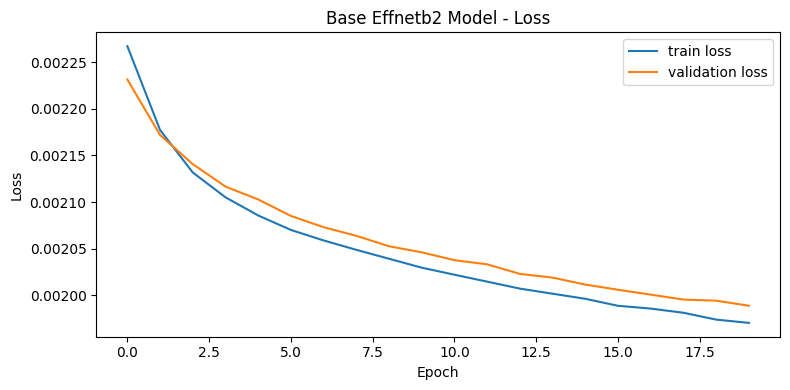

In [92]:
plot_loss_curves(base_effnetb2_results_df, model_name="Base Effnetb2")

You can observe that the model performs better on the training data compared to the validation data, indicating that it is struggling to generalize to unseen data, which suggests overfitting. In the next experiment, I will incorporate data augmentation to potentially improve the model’s performance. Fingers crossed!

On the hand the loss is descending which indicates convergence so that's awesome.

In [93]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from enum import Enum, auto


# Enum for the metric types
class Metric(Enum):
    ACCURACY = 'accuracy'
    PRECISION = 'precision'
    RECALL = 'recall'
    F1 = 'f1'

def get_metrics(results: pd.DataFrame, metric: Metric, thresholds: list[int]) -> dict:
    """
    Compute various metrics for training and validation data across multiple epochs and thresholds.

    Args:
    - results (pd.DataFrame): DataFrame containing 'train_predictions', 'validation_predictions',
                              'train_labels', and 'validation_labels' for each epoch.
    - metric (Metric): The metric type to compute (e.g., accuracy, precision, recall, f1).
    - thresholds (list[int]): List of threshold values for binary conversion.

    Returns:
    - dict: Dictionary with computed metrics including accuracy scores, precision, recall, and f1 scores
            for each epoch and threshold.
    """
    # Initialize lists to store metrics for each epoch and threshold
    epoch_list = []
    threshold_list = []
    train_genre_metrics = []
    train_style_metrics = []

    val_genre_metrics = []
    val_style_metrics = []

    # Extract predictions and labels from results DataFrame
    train_genre_predictions = results['train_genre_predictions']
    train_style_predictions = results['train_style_predictions']

    val_genre_predictions = results['validation_genre_predictions']
    val_style_predictions = results['validation_style_predictions']

    train_genre_labels = results['train_genre_labels']
    train_style_labels = results['train_style_labels']

    val_genre_labels = results['validation_genre_labels']
    val_style_labels = results['validation_style_labels']

    epochs = range(len(results))

    for epoch in epochs:
        for threshold in thresholds:
            epoch_list.append(epoch)
            threshold_list.append(threshold)

            # Convert predictions to binary using the current threshold
            train_genre_predictions_binary = (train_genre_predictions[epoch] > threshold).astype(int)
            train_style_predictions_binary = (train_style_predictions[epoch] > threshold).astype(int)

            val_genre_predictions_binary = (val_genre_predictions[epoch] > threshold).astype(int)
            val_style_predictions_binary = (val_style_predictions[epoch] > threshold).astype(int)

            # Compute metrics based on the selected metric type
            match metric:
                case Metric.ACCURACY:
                    t_genre_metric = accuracy_score(train_genre_labels[epoch], train_genre_predictions_binary)
                    t_style_metric = accuracy_score(train_style_labels[epoch], train_style_predictions_binary)

                    v_genre_metric = accuracy_score(val_genre_labels[epoch], val_genre_predictions_binary)
                    v_style_metric = accuracy_score(val_style_labels[epoch], val_style_predictions_binary)
                case Metric.PRECISION:
                    t_genre_metric = precision_score(train_genre_labels[epoch], train_genre_predictions_binary,
                                                     zero_division=0, average='samples')
                    t_style_metric = precision_score(train_style_labels[epoch], train_style_predictions_binary,
                                                     zero_division=0, average='samples')

                    v_genre_metric = precision_score(val_genre_labels[epoch], val_genre_predictions_binary,
                                                     zero_division=0, average='samples')
                    v_style_metric = precision_score(val_style_labels[epoch], val_style_predictions_binary,
                                                     zero_division=0, average='samples')
                case Metric.RECALL:
                    t_genre_metric = recall_score(train_genre_labels[epoch], train_genre_predictions_binary, average='samples')
                    t_style_metric = recall_score(train_style_labels[epoch], train_style_predictions_binary, average='samples')

                    v_genre_metric = recall_score(val_genre_labels[epoch], val_genre_predictions_binary, average='samples')
                    v_style_metric = recall_score(val_style_labels[epoch], val_style_predictions_binary, average='samples')
                case Metric.F1:
                    t_genre_metric = f1_score(train_genre_labels[epoch], train_genre_predictions_binary, average='samples')
                    t_style_metric = f1_score(train_style_labels[epoch], train_style_predictions_binary, average='samples')

                    v_genre_metric = f1_score(val_genre_labels[epoch], val_genre_predictions_binary, average='samples')
                    v_style_metric = f1_score(val_style_labels[epoch], val_style_predictions_binary, average='samples')

            # Append calculated metrics
            train_genre_metrics.append(t_genre_metric)
            train_style_metrics.append(t_style_metric)

            val_genre_metrics.append(v_genre_metric)
            val_style_metrics.append(v_style_metric)

    # Return a dictionary containing all computed metrics
    return {
        'epoch': epoch_list,
        'threshold': threshold_list,
        'train_genre_metrics': train_genre_metrics,
        'train_style_metrics': train_style_metrics,
        'val_genre_metrics': val_genre_metrics,
        'val_style_metrics': val_style_metrics
    }


In [94]:
# getting accuracy the metrics for the model
base_effnetb2_accuracies = pd.DataFrame(get_metrics(results=base_effnetb2_results_df,
                                                    metric=Metric.ACCURACY,
                                                    thresholds=THRESHOLDS))
base_effnetb2_accuracies.head()

epoch  threshold  train_genre_metrics  train_style_metrics  \
0      0        0.6             0.000000             0.000000   
1      0        0.7             0.000412             0.000412   
2      0        0.8             0.000000             0.000000   
3      1        0.6             0.000000             0.000000   
4      1        0.7             0.018144             0.028041   

   val_genre_metrics  val_style_metrics  
0           0.000000           0.000000  
1           0.000000           0.001546  
2           0.000000           0.000000  
3           0.000000           0.000000  
4           0.014683           0.023184

<h3>Plot Accuracy per Threashold for Training and Validation</h3>

The plot provides insights into the model's performance on both the training and validation data across different thresholds.


In [95]:

def plot_metrics_with_thresholds(results: pd.DataFrame, model_name: str, metric:Metric, thresholds: list[int]) -> None:

    metric_name = metric.value.capitalize()

    fig, ax = plt.subplots(2, 3, figsize=(18, 8), sharex=True, sharey=True)
    fig.suptitle(f"{model_name} Model - {metric_name} by Threshold")

    # Flatten the axes array for easier indexing
    ax = ax.flatten()

    # Define colors for the plots
    color_train = 'blue'
    color_val = 'orange'

    # Plot all data
    for idx, threshold in enumerate(thresholds):
        # Get data for the current threshold
        data = results[results['threshold'] == threshold]

        # Plot genre metric
        data_genre = data[['epoch', 'train_genre_metrics', 'val_genre_metrics']]
        ax[idx].plot(data_genre['epoch'], data_genre['train_genre_metrics'], label="Train", color=color_train)
        ax[idx].plot(data_genre['epoch'], data_genre['val_genre_metrics'], label="Validation", color=color_val)
        ax[idx].set_title(f"Genre {metric_name} (Threshold {threshold})")
        ax[idx].set_xlabel("Epochs")
        ax[idx].set_ylabel(metric_name)

        # Plot style metric
        data_style = data[['epoch', 'train_style_metrics', 'val_style_metrics']]
        ax[idx + 3].plot(data_style['epoch'], data_style['train_style_metrics'], label="Train", color=color_train)
        ax[idx + 3].plot(data_style['epoch'], data_style['val_style_metrics'], label="Validation", color=color_val)
        ax[idx + 3].set_title(f"Style {metric_name} (Threshold {threshold})")
        ax[idx + 3].set_xlabel("Epochs")
        ax[idx + 3].set_ylabel(metric_name)

    # Add a single legend for the entire figure
    handles, labels = ax[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', ncol=2)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

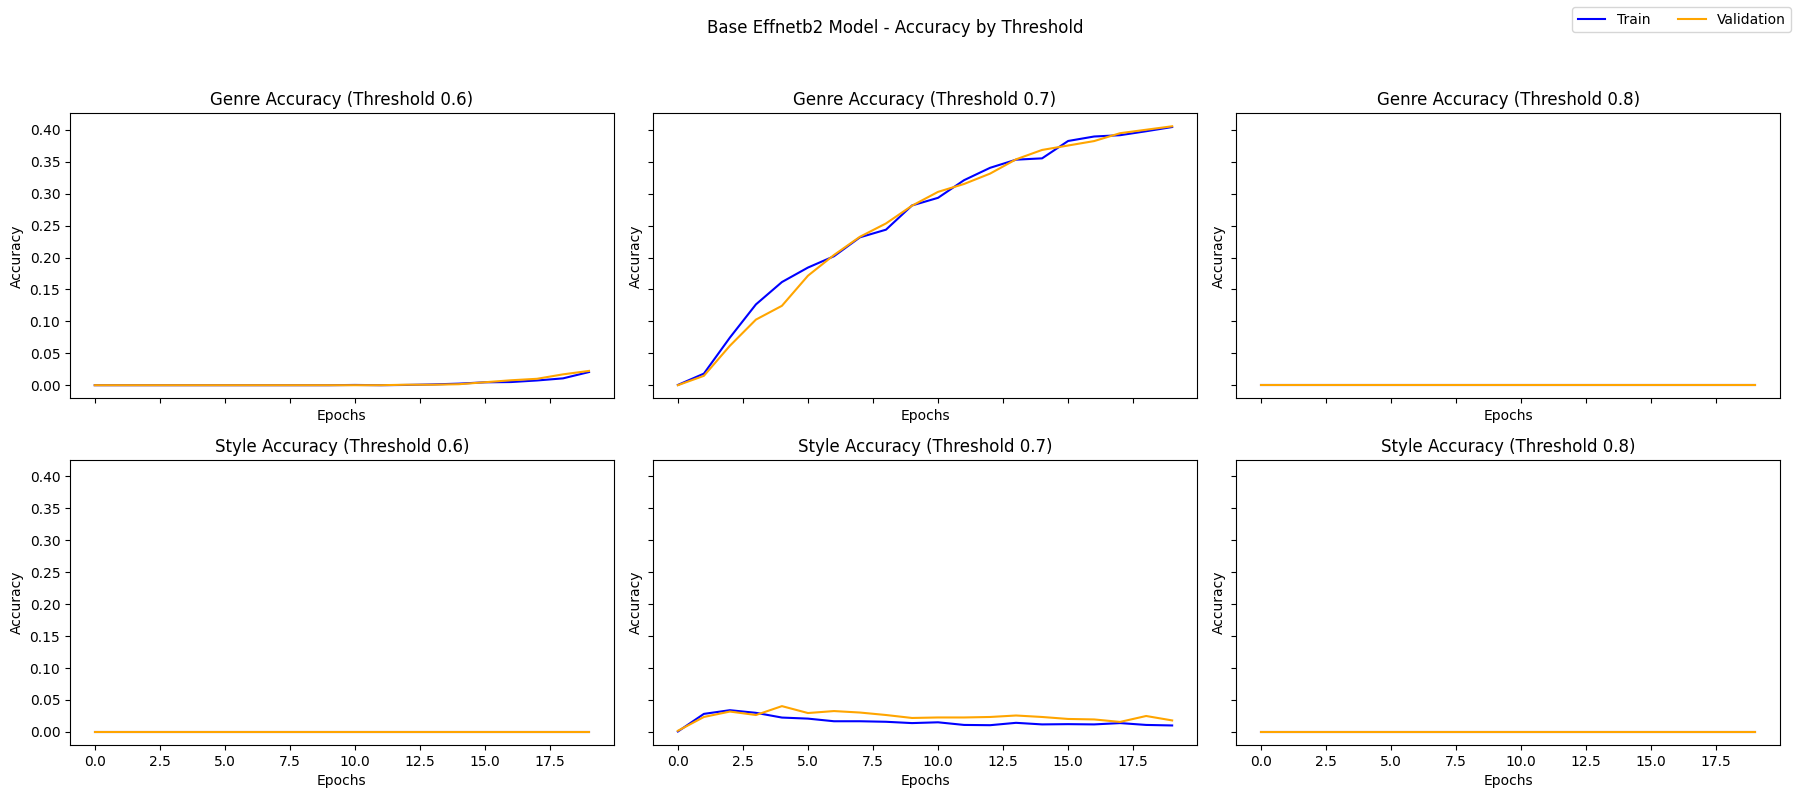

In [96]:
plot_metrics_with_thresholds(results=base_effnetb2_accuracies,
                             model_name="Base Effnetb2",
                             metric=Metric.ACCURACY,
                             thresholds=THRESHOLDS)

It seems that the optimal threshold is 0.7. The accuracy trend for genre looks good.  However the model seems to struggle on the style labels.    

<h3>Plot F1 Score per Threashold for Training and Validation</h3>

How is the model doing on average between "harmonic mean" between Precision and Recall?

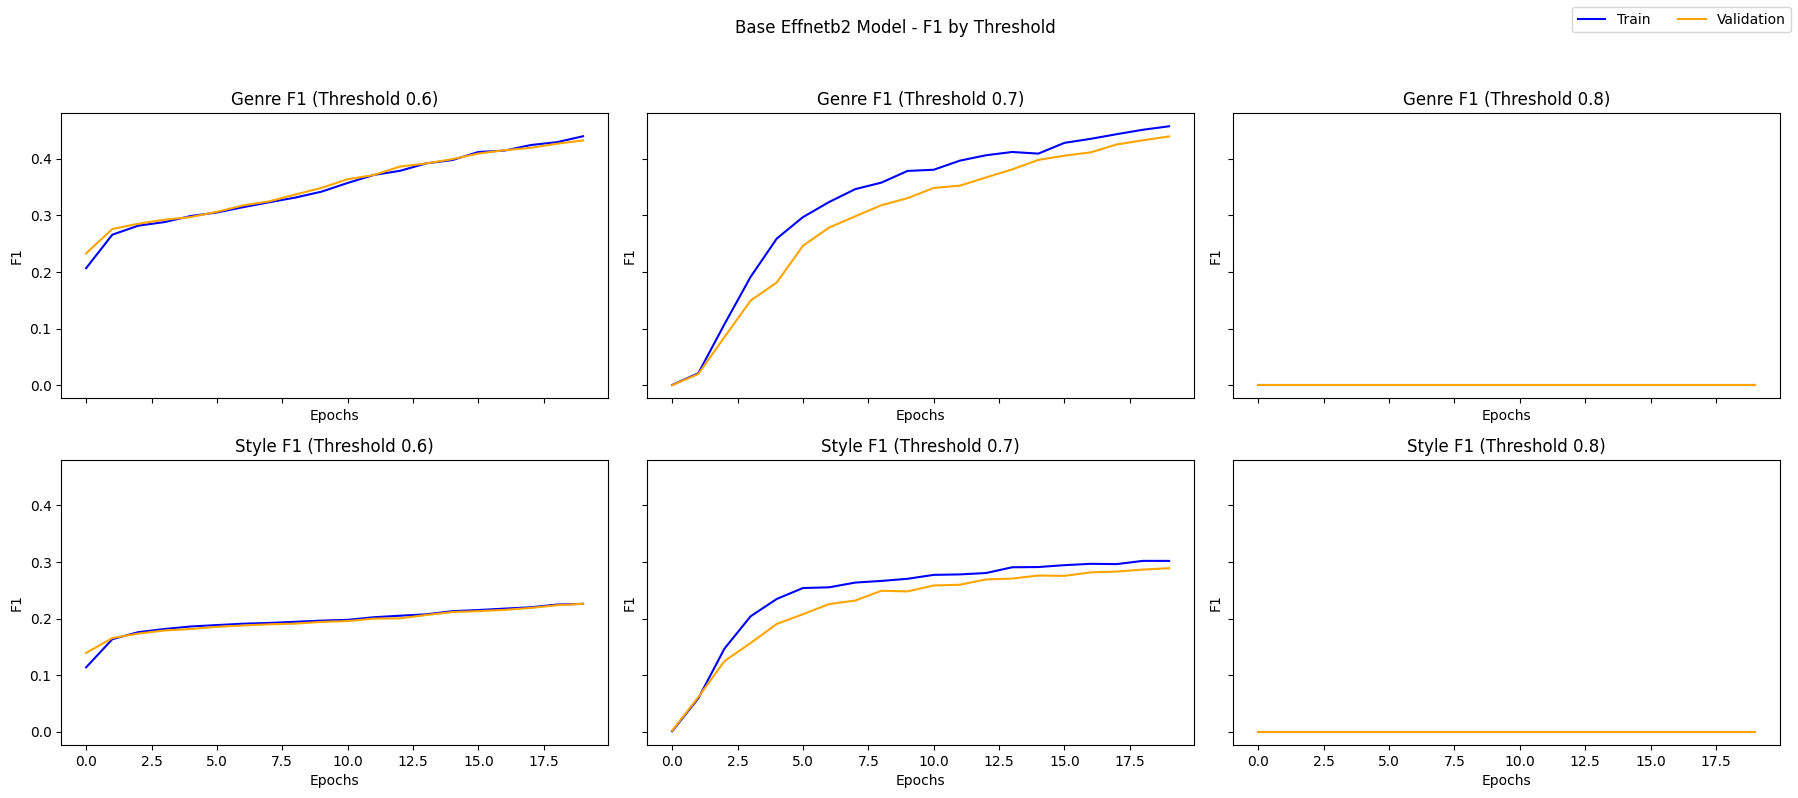

In [97]:
# getting f1 score
base_effnetb2_f1_scores = pd.DataFrame(get_metrics(results=base_effnetb2_results_df,
                                                    metric=Metric.F1,
                                                    thresholds=THRESHOLDS))
# plot results
plot_metrics_with_thresholds(results=base_effnetb2_f1_scores,
                             model_name="Base Effnetb2",
                             metric=Metric.F1,
                             thresholds=THRESHOLDS)

TBD

<h3>Plot Precision Score per Threashold for Training and Validation</h3>

Out of all the positive predictions, how many of them were correct?

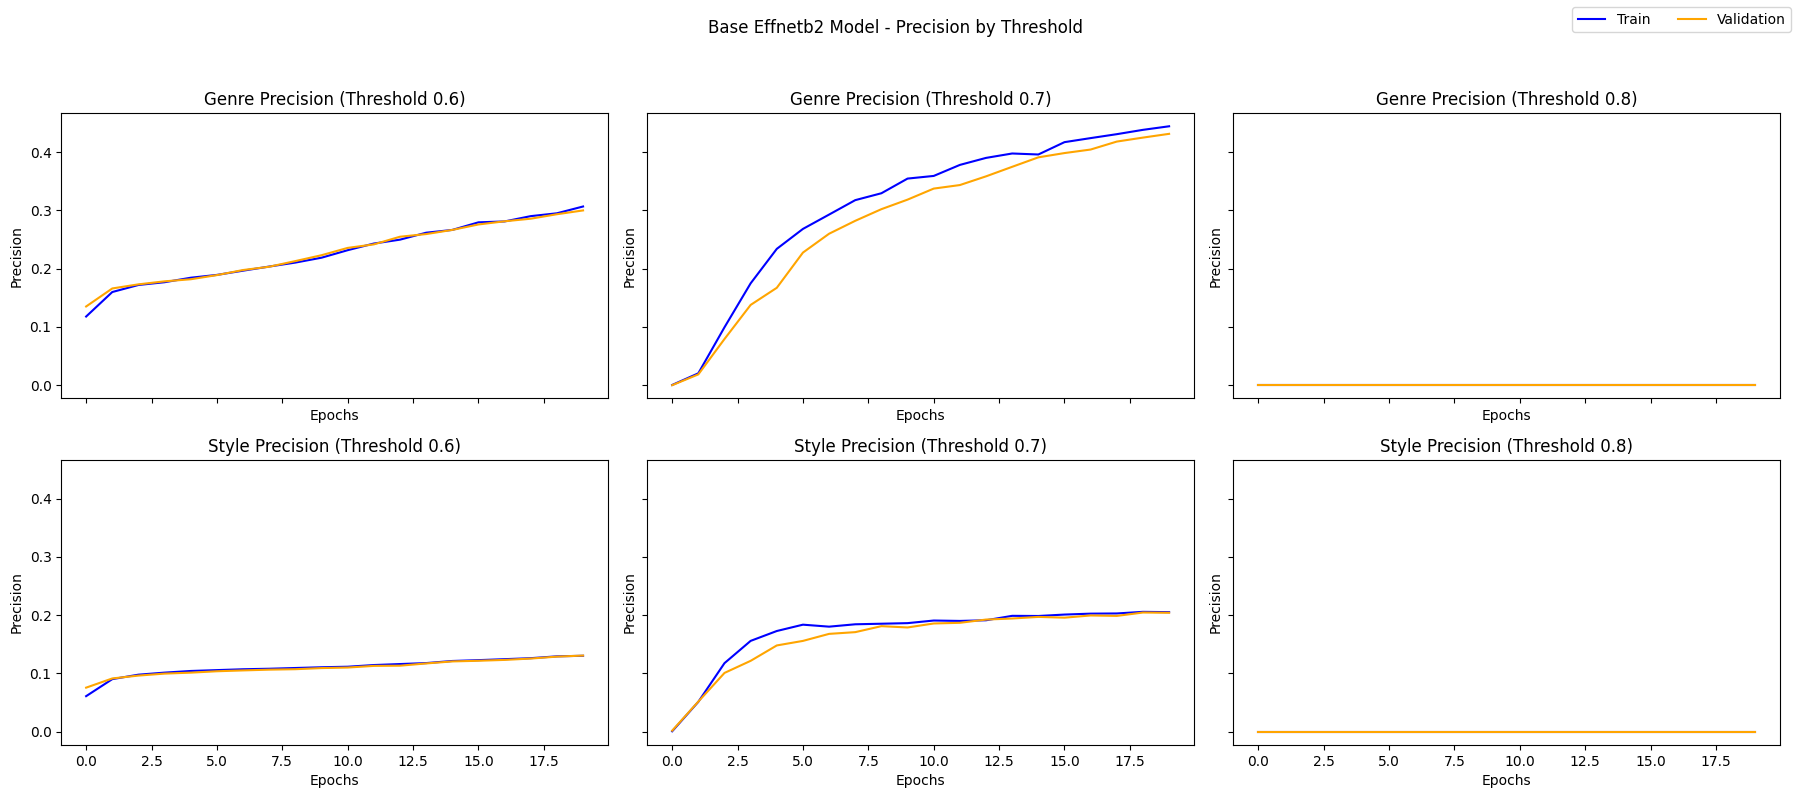

In [98]:
# getting precision score
base_effnetb2_precision_scores = pd.DataFrame(get_metrics(results=base_effnetb2_results_df,
                                                    metric=Metric.PRECISION,
                                                    thresholds=THRESHOLDS))
# plot results
plot_metrics_with_thresholds(results=base_effnetb2_precision_scores,
                             model_name="Base Effnetb2",
                             metric=Metric.PRECISION,
                             thresholds=THRESHOLDS)

Look at the genre precision go! I'm so proud. This means that, on average, when the model predicts a specific genre, it is correct for that genre. High precision indicates that the genre predictions are reliable, with a low rate of false positives.

<h3>Plot Recall Score per Threashold for Training and Validation</h3>

Out of all the positive cases available, how many did the model find?

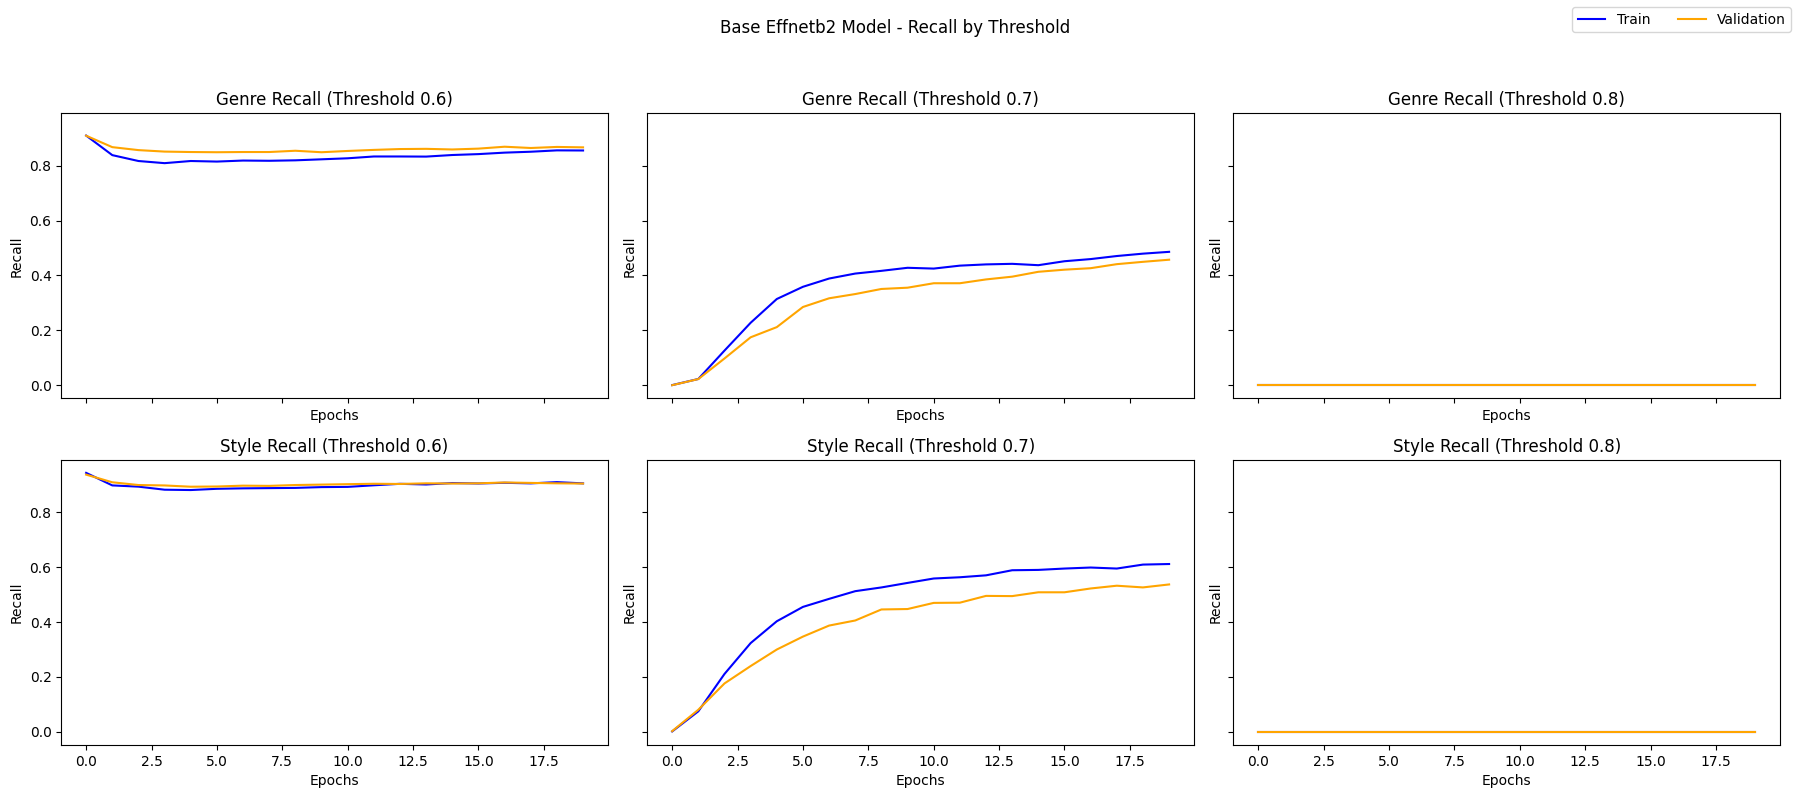

In [99]:
# getting recall score
base_effnetb2_recall_scores = pd.DataFrame(get_metrics(results=base_effnetb2_results_df,
                                                    metric=Metric.RECALL,
                                                    thresholds=THRESHOLDS))
# plot results
plot_metrics_with_thresholds(results=base_effnetb2_recall_scores,
                             model_name="Base Effnetb2",
                             metric=Metric.RECALL,
                             thresholds=THRESHOLDS)

This is interesting. The threshold 0.6 seems to stay steady above 0.7.  So the model found more positive cases at 0.6 threshold than at 0.7 threshold?

<h3>Predicting on Unseen Data</h3>

Next, I'll make predictions on a selection of random images from the test data. I must admit, visualizing how accurately these predictions match the ground truth is the most exciting part of the process.

In [100]:

def get_decoded_labels(genre_label: np.ndarray, style_label: np.ndarray, threshold: float = BEST_THRESHOLD) -> tuple:
    """
    Decode the predicted labels into their respective agenre, and style.

    Parameters:
    - genre_label (np.ndarray): The predicted genre labels as probabilities.
    - style_label (np.ndarray): The predicted style labels as probabilities.
    - threshold (float, optional): The threshold for converting probabilities to binary labels.

    Returns:
    - tuple: Decoded genre and style.
    """
    UNKNOWN_VALUE = '<not found>'

    # convert predictions to binary based on the threshold
    genre_label_binary = (genre_label > threshold).astype(int)
    style_label_binary = (style_label > threshold).astype(int)

    # ensure `label_binary` is a 2D array with shape (1, num_labels)
    genre_label_binary_2d = genre_label_binary.reshape(1, -1)
    style_label_binary_2d = style_label_binary.reshape(1, -1)

    # Perform inverse transform for each label type
    decoded_genres = mlb_genre.inverse_transform(genre_label_binary_2d)
    decoded_styles = mlb_style.inverse_transform(style_label_binary_2d)

    # Map decoded labels to their respective categories or return UNKNOWN_VALUE
    genre = genres[decoded_genres[0][0]] if decoded_genres[0] else UNKNOWN_VALUE
    style = styles[decoded_styles[0][0]] if decoded_styles[0] else UNKNOWN_VALUE

    return genre, style

In [101]:
def preprocess_image(image_path: str, transform=None) -> torch.Tensor:
    """
    Load and preprocess an image.

    Parameters:
    - image_path (str): Path to the image file.
    - transform (callable, optional): A transform to apply to the image.

    Returns:
    - torch.Tensor: The preprocessed image.
    """
    # Load the image
    image = torchvision.io.read_image(image_path).float()

    # Normalize pixel values to [0, 1]
    image /= 255.0

    # Apply additional transformations if provided
    if transform:
        image = transform(image)

    return image


In [102]:
import matplotlib.pyplot as plt
import random
import numpy as np

def pred_and_plot_images(model:torch.nn.Module, image_paths:list[str], annotations_df,
                         transform=None, threshold:float=BEST_THRESHOLD) -> None:
  """
  Makes a prediction on a target image with a trained model and plots the image.

  Args:
    model (torch.nn.Module): trained PyTorch image classification model.
    image_path (str): filepath to target image.
    annotations_df: dataframe that contain the annotations
    transform (_type_, optional): transform of target image. Defaults to None.
    threshold (int, optional): the threshold
  """

  # define the number of artworks to display and the grid layout
  art_count = len(image_paths)
  cols = 4
  rows = art_count // cols
  num_genres = len(unique_genres)

  # set up the plot
  plt.figure(figsize=(12, 4 * rows))

  # make sure the model is on the target device
  model.to(device)

  # turn on model evaluation mode
  model.eval()

  for i in range(rows * cols):
    # pre-process image
    target_image = preprocess_image(image_paths[i], transform)

    with torch.inference_mode():
      # add an extra dimension to the image
      target_image = target_image.unsqueeze(dim=0).to(device)

      # make a prediction
      target_image_pred = model(target_image.to(device))
      genre_logits = target_image_pred[:, :num_genres]
      style_logits = target_image_pred[:, num_genres:]

      genre_preds = torch.sigmoid(genre_logits).cpu().numpy()
      style_preds = torch.sigmoid(style_logits).cpu().numpy()

    # get the corresponding true labels
    true_labels = annotations_df[annotations_df['image_name'] == image_paths[i].name]

    pred_genre, pred_style = get_decoded_labels(np.array(genre_preds),
                                               np.array(style_preds),
                                               threshold=threshold)

    true_genre, true_style = get_decoded_labels(np.array(true_labels['genre'].tolist()),
                                                np.array(true_labels['style'].tolist()),
                                                threshold=threshold)

    pred_color = 'b' if pred_genre == true_genre and pred_style == true_style else 'r'

    genre_text = f'** Genre: {pred_genre}' if pred_genre != true_genre else f'Genre: {pred_genre}'
    style_text = f'** Style: {pred_style}' if pred_style != true_style else f'Style: {pred_style}'

    # plot the image
    ax = plt.subplot(rows, cols, i + 1)

    plt.imshow(Image.open(image_paths[i]))
    plt.title(f"{genre_text} | {genre_preds.max():.2%}\n{style_text} | {style_preds.max():.2%}",
              fontsize=10, c=pred_color)

    plt.axis('off')

  # show the plot
  plt.tight_layout()
  plt.show()

In [103]:
import random
import torch
from pathlib import Path
from typing import Callable, List, Optional

def predict_random_test_images(
    model: torch.nn.Module,
    test_dir: Path,
    annotations_df,
    transform = None,
    img_count: int = 8,
    threshold: float = 0.6
) -> None:
    """
    Predict and plot random test images using the provided model.

    Parameters:
    - model (torch.nn.Module): The trained model to make predictions.
    - test_dir (Path): Directory containing test images.
    - annotations_df: dataframe that contain the annotations
    - transform (Callable, optional): A transform to apply to the images.
    - img_count (int, optional): Number of random images to select. Default is 8.
    - threshold (float, optional): Threshold for making predictions. Default is 0.6.

    Returns:
    - None
    """
    # Get all image paths from the test directory
    img_path_list = list(test_dir.glob('*.jpg'))

    # Sample random images
    selected_images = random.sample(img_path_list, k=img_count)

    # Predict and plot the selected images
    pred_and_plot_images(model=model, image_paths=selected_images, annotations_df=annotations_df, transform=transform)

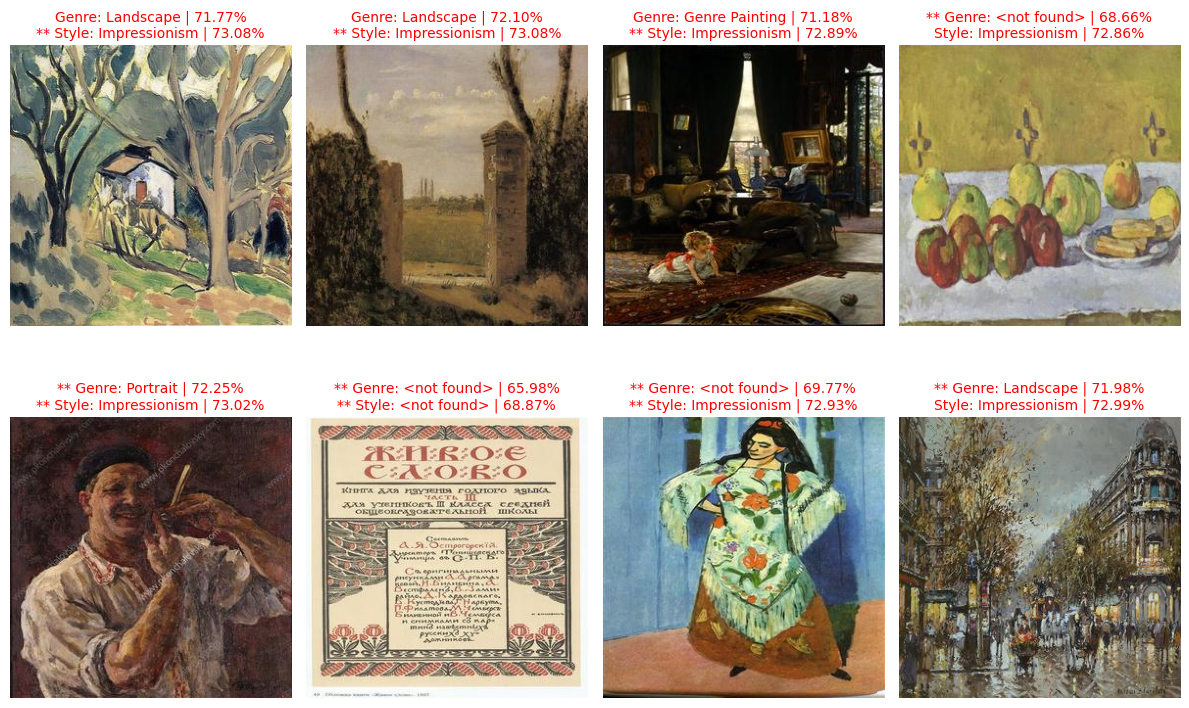

In [112]:
test_images = test_dir / 'images'

predict_random_test_images(model=base_effnetb2,
                           test_dir=test_images,
                           annotations_df=test_annotations_10pt,
                           transform=base_effnetb2_transforms)

The model seems to good at predicting the landscape genre. It generally predicts one out of 3 labels.  And that label on average is genre.  Which is not a surprise when looking at the Precision and Recall.

<h3>Collect Test Metrics</h3>

Feeding the model unseen data and collecting the loss, accuracy, f1 score, precision score, and recall score.  This will assist comparing the model to the others and deciding which is the best performing model.

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def get_test_metrics(artist_preds, genre_preds, style_preds,
                     artist_lbls, genre_lbls, style_lbls, threshold):

    genre_preds_binary = (genre_preds > threshold).astype(int)
    style_preds_binary = (style_preds > threshold).astype(int)

    metrics = {
        'genre_accuracy': accuracy_score(genre_lbls, genre_preds_binary),
        'style_accuracy': accuracy_score(style_lbls, style_preds_binary),
        'genre_precision': precision_score(genre_lbls, genre_preds_binary, zero_division=0, average='samples'),
        'style_precision': precision_score(style_lbls, style_preds_binary, zero_division=0, average='samples'),
        'genre_recall': recall_score(genre_lbls, genre_preds_binary, average='samples'),
        'style_recall': recall_score(style_lbls, style_preds_binary, average='samples'),
        'genre_f1': f1_score(genre_lbls, genre_preds_binary, average='samples'),
        'style_f1': f1_score(style_lbls, style_preds_binary, average='samples')
    }

    return metrics

def evaluate_model(model: nn.Module,
                    model_name: str,
                    dataloader: torch.utils.data.DataLoader,
                    genre_loss_fn: nn.Module,
                    style_loss_fn: nn.Module,
                    device: torch.device,
                    num_genres: int,
                    threshold: float) -> pd.DataFrame:
    """
    Calculates metrics with the model predictions on test data.

    Args:
    model (nn.Module): A PyTorch model to be tested.
    dataloader (torch.utils.data.DataLoader): A DataLoader instance for the model to be tested on.
    genre_loss_fn (nn.Module): A PyTorch loss function for genres.
    style_loss_fn (nn.Module): A PyTorch loss function for styles.
    device (torch.device): A target device to compute on (e.g., "cuda" or "cpu").
    num_genres (int): Number of unique genres.
    threshold (float): Threshold for binary classification.

    Returns:
    dict: Metrics including loss, accuracy, precision, recall, and F1 score.
    """
    model.eval()
    loss = 0.0
    total_items = len(dataloader)
    genre_preds_bkt = []
    style_preds_bkt = []
    genre_lbls_bkt = []
    style_lbls_bkt = []

    with torch.inference_mode():
        for images, genres, styles in tqdm(dataloader, total=total_items, desc='Testing...'):
            images, genres, styles = images.to(device), genres.to(device), styles.to(device)

            y_pred_logits = model(images)
            genre_logits = y_pred_logits[:, :num_genres]
            style_logits = y_pred_logits[:, num_genres:]

            genre_loss = genre_loss_fn(genre_logits, genres)
            style_loss = style_loss_fn(style_logits, styles)
            total_loss = genre_loss + style_loss
            loss += total_loss.item()

            genre_preds = torch.sigmoid(genre_logits).detach().cpu().numpy()
            style_preds = torch.sigmoid(style_logits).detach().cpu().numpy()

            genre_preds_bkt.extend(genre_preds)
            style_preds_bkt.extend(style_preds)

            genre_lbls_bkt.extend(genres.detach().cpu().numpy())
            style_lbls_bkt.extend(styles.detach().cpu().numpy())

    genre_preds_bkt = np.array(genre_preds_bkt)
    style_preds_bkt = np.array(style_preds_bkt)

    genre_lbls_bkt = np.array(genre_lbls_bkt)
    style_lbls_bkt = np.array(style_lbls_bkt)

    metrics = get_test_metrics(genre_preds_bkt, style_preds_bkt, genre_lbls_bkt, style_lbls_bkt, threshold)
    metrics['model_name'] = model_name
    metrics['loss'] = loss / total_items

    return metrics


In [ ]:
metrics = evaluate_model(model=base_effnetb2,
                    model_name = 'base_effnetb2',
                    dataloader = test_dataloader,
                    genre_loss_fn = genre_loss_fn,
                    style_loss_fn = style_loss_fn,
                    device = device,
                    num_genres = len(unique_genres),
                    threshold = BEST_THRESHOLD)


df_metrics = pd.DataFrame([metrics])
df_metrics.head()

### Experiment 2 (Augmented EffNetB2)

#### Create Model

In [ ]:
aug_effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=num_classes)

In [ ]:
effnetb2_transforms

In [ ]:
from torchvision import transforms

# create transforms
aug_effnetb2_transforms = torchvision.transforms.Compose([transforms.RandomHorizontalFlip(),
                                                          transforms.RandomRotation(20),
                                                          transforms.RandomVerticalFlip(),
                                                          effnetb2_transforms])
aug_effnetb2_transforms

In [ ]:
# just to be sure everything is what I expect
summary(aug_effnetb2,
        input_size=(1, 3, 288, 288),
        col_names=['input_size','output_size','num_params','trainable'],
        col_width=20,
        row_settings=['var_names'])

#### Create Dataloaders

In [ ]:
train_dataloader, val_dataloader, test_dataloader= data_setup(train_transform=aug_effnetb2_transforms,
                                                                        test_transform=effnetb2_transforms,
                                                                        train_annotations=train_annotations_path,
                                                                        val_annotations=val_annotations_path,
                                                                        test_annotations=test_annotations_path,
                                                                        train_images=train_images_path,
                                                                        val_images=val_images_path,
                                                                        test_images=test_images_path,
                                                                        num_workers=NUM_WORKERS,
                                                                        batch_size=BATCH_SIZE)

#### Train Model

In [ ]:
# get balanced weights for the classes
genre_weights, style_weights = get_genre_and_style_weights(train_dataloader,len(mlb_genre.classes_),len(mlb_style.classes_))

# create loss functions with the balanced weights
genre_loss_fn = nn.CrossEntropyLoss(weight= genre_weights)
style_loss_fn = nn.CrossEntropyLoss(weight= style_weights)

# init optimizer with L2 regularization
optimizer = optim.AdamW(aug_effnetb2.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1)

In [ ]:
# Training function
set_seeds()

with track_time():
  aug_effnetb2_results = train(model=aug_effnetb2,
                                train_dataloader=train_dataloader,
                                validation_dataloader=val_dataloader,
                                optimizer=optimizer,
                                scheduler=scheduler,
                                genre_loss_fn=genre_loss_fn,
                                style_loss_fn=style_loss_fn,
                                epochs=EPOCHS,
                                num_genres=len(unique_genres),
                                device=device)

<h3>My First Thoughts:</h3>
The base model last epoch train loss was 0.0042 and validation loss was 0.0043 so with augmenations the loss has not really changed.  **BUT** making the images harder to predict by adding augmentations got rid of that slight overfit from before.

####Model Performance Evaluation
In this section, I will evaluate model performance. I will plotting the following..

* Loss curve for combination of artist, genre, and style losses:  If the trend is descending, which it is, then it's converging.
* Artists, genre, and style accuracies: The proportion of correctly predicted labels to the total number of labels for each instance. The higher the score, the better the model's performance.
* Average F1 Score for each label
* Average Recall Score for each label
* Average Precision Score for each label
* Finally, predictions will be made on the test data, and the results will be displayed.


Note:  What's important here is where the scores are trending and what the model seems to have trouble with.  The actual scores will be more important when I train the final model.


In [ ]:
# taking a look at the results
aug_effnetb2_results_df = pd.DataFrame(aug_effnetb2_results)
aug_effnetb2_results_df.head()

<h3>Plot Loss for Training and Validation</h3>

This plot visualizes the training and validation loss values per epoch. It helps in understanding whether the model is learning effectively and in identifying any signs of overfitting or underfitting.

In [ ]:
plot_loss_curves(aug_effnetb2_results_df, model_name="Augmented Effnetb2")

Welp!  Spoke too soon.  This model is overfitting on the training data. It's converging but it is also overfitting.

<h3>Plot Accuracy per Threashold for Training and Validation</h3>

The plot provides insights into the model's performance on both the training and validation data across different thresholds.

In [ ]:
# getting accuracy the metrics for the model
aug_effnetb2_accuracies = pd.DataFrame(get_metrics(results=aug_effnetb2_results_df,
                                                    metric=Metric.ACCURACY,
                                                    thresholds=THRESHOLDS))

plot_metrics_with_thresholds(results=aug_effnetb2_accuracies,
                             model_name="Augmented Effnetb2",
                             metric=Metric.ACCURACY,
                             thresholds=THRESHOLDS)

It looks like the added augmentation has not changed the model predictive capability.  It looks the pretty much the same as the base model here.

<h3>Plot F1 Score per Threashold for Training and Validation</h3>

How is the model doing on average between "harmonic mean" between Precision and Recall?

In [ ]:
# getting f1 score
aug_effnetb2_f1_scores = pd.DataFrame(get_metrics(results=aug_effnetb2_results_df,
                                                    metric=Metric.F1,
                                                    thresholds=THRESHOLDS))
# plot results
plot_metrics_with_thresholds(results=aug_effnetb2_f1_scores,
                             model_name="Augmented Effnetb2",
                             metric=Metric.F1,
                             thresholds=THRESHOLDS)

Just like before ariist is hard for the model to predict.

<h3>Plot Precision Score per Threashold for Training and Validation</h3>

Out of all the positive predictions, how many of them were correct?




In [ ]:
# getting precision score
aug_effnetb2_precision_scores = pd.DataFrame(get_metrics(results=aug_effnetb2_results_df,
                                                    metric=Metric.PRECISION,
                                                    thresholds=THRESHOLDS))
# plot results
plot_metrics_with_thresholds(results=aug_effnetb2_precision_scores,
                             model_name="Augmented Effnetb2",
                             metric=Metric.PRECISION,
                             thresholds=THRESHOLDS)

There isn't much to say here except augmentation didn't really seem to pay off.

<h3>Plot Recall Score per Threashold for Training and Validation</h3>

Out of all the positive cases available, how many did the model find?



In [ ]:
# getting recall score
aug_effnetb2_recall_scores = pd.DataFrame(get_metrics(results=aug_effnetb2_results_df,
                                                    metric=Metric.RECALL,
                                                    thresholds=THRESHOLDS))
# plot results
plot_metrics_with_thresholds(results=aug_effnetb2_recall_scores,
                             model_name="Augmented Effnetb2",
                             metric=Metric.RECALL,
                             thresholds=THRESHOLDS)

I think the recall looks slightly better, maybe.

<h3>Predicting on Unseen Data</h3>

Next, I'll make predictions on a selection of random images from the test data. I must admit, visualizing how accurately these predictions match the ground truth is the most exciting part of the process.


In [ ]:
test_images = test_dir / 'images'

predict_random_test_images(model=aug_effnetb2,
                           test_dir=test_images,
                           annotations_df=test_annotations_10pt,
                           transform=effnetb2_transforms)

The EffNetB2 model, even with data augmentation, is still making frequent incorrect predictions. It might be time to move on from EfficientNet models and experiment with transformers. Transformers have shown superior performance compared to convolutional neural networks in many cases, so I'm optimistic about seeing improved results with them.

<h3>Collect Test Metrics</h3>

Feeding the model unseen data and collecting the loss, accuracy, f1 score, precision score, and recall score.  This will assist comparing the model to the others and deciding which is the best performing model.

In [ ]:
metrics = evaluate_model(model=aug_effnetb2,
                    model_name = 'aug_effnetb2',
                    dataloader = test_dataloader,
                    genre_loss_fn = genre_loss_fn,
                    style_loss_fn = style_loss_fn,
                    device = device,
                    num_genres = len(unique_genres),
                    threshold = BEST_THRESHOLD)

temp_df = pd.DataFrame([metrics])
df_metrics = pd.concat([df_metrics, temp_df], ignore_index=True)
df_metrics.head()

### Experiment 3 (ViT)

In [ ]:
# Get pretrained weights for ViT-Base
base_pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # "DEFAULT" = best available

# Setup a ViT model instance with pretrained weights
base_pretrained_vit = torchvision.models.vit_b_16(weights=base_pretrained_vit_weights).to(device)

# Upate the classifier head
set_seeds()

In [ ]:
vit_transforms = base_pretrained_vit_weights.transforms()
vit_transforms

In [ ]:
from torchinfo import summary

summary(model=base_pretrained_vit,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

In [ ]:
base_pretrained_vit.heads

The ViT model is significantly larger than EfficientNet. I will freeze all layers except for the output layer, where I'll update the number of class names and add a sigmoid activation function for multilabel classification.

#### Create Model

In [ ]:
#%%writefile modules/create_vit_model.py
"""Contains function for creating a ViT model with a sigmoid layer added to the output to handle multi-label classification.
"""
from torch import nn
import torchvision
from torchvision import transforms

def create_vit_model(num_classes=10, seed=42, device='cpu') -> tuple[torchvision.models.vit_b_16, torchvision.transforms.Compose]:
    """
    Creates a ViT-B16 model with a custom classifier head and specified transformations.

    Parameters:
    num_classes (int): The number of output classes.
    seed (int): Random seed for reproducibility.
    device (str): Device to load the model on ('cpu' or 'cuda').

    Returns:
    tuple: A tuple containing the ViT-B16 model and the transformations used.
    """

    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transform = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    # Freeze the base parameters
    for parameter in model.parameters():
        parameter.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)

    # Update the model head for multi-label classification
    model.heads = nn.Sequential(
        nn.Linear(in_features=768, out_features=num_classes),
        nn.Sigmoid()
    ).to(device)

    return model, transform


In [ ]:
num_classes = len(unique_genres) + len(unique_styles)

base_vitb16, base_vitb16_transforms = create_vit_model(num_classes=num_classes)

In [ ]:
# Print base ViT summary
summary(base_vitb16,
        input_size=(1, 3, 224, 224),
        col_names=['input_size','output_size','num_params','trainable'],
        col_width=20,
        row_settings=['var_names'])


*   51 classes
*   Sigmoid function added to the output
*   39,219 trainable params

Looks good!



#### Create Dataloaders

In [ ]:
train_dataloader, val_dataloader, test_dataloader = data_setup(train_transform=base_vitb16_transforms,
                                                                        test_transform=base_vitb16_transforms,
                                                                        train_annotations=train_annotations_path,
                                                                        val_annotations=val_annotations_path,
                                                                        test_annotations=test_annotations_path,
                                                                        train_images=train_images_path,
                                                                        val_images=val_images_path,
                                                                        test_images=test_images_path,
                                                                        num_workers=NUM_WORKERS,
                                                                        batch_size=BATCH_SIZE)

#### Train Model

In [ ]:
# get balanced weights for the classes
genre_weights, style_weights = get_genre_and_style_weights(train_dataloader,len(mlb_genre.classes_),len(mlb_style.classes_))

# create loss functions with the balanced weights
genre_loss_fn = nn.CrossEntropyLoss(weight= genre_weights)
style_loss_fn = nn.CrossEntropyLoss(weight= style_weights)

# init optimizer with L2 regularization
optimizer = optim.AdamW(base_vitb16.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1)

In [ ]:
# Training function
set_seeds()

with track_time():
  base_vitb16_results = train(model=base_vitb16,
                                train_dataloader=train_dataloader,
                                validation_dataloader=val_dataloader,
                                optimizer=optimizer,
                                scheduler=scheduler,
                                genre_loss_fn=genre_loss_fn,
                                style_loss_fn=style_loss_fn,
                                epochs=EPOCHS,
                                num_genres=len(unique_genres),
                                device=device)

<h3>My First Thoughts:</h3>
You don't see a lot of my previous mistakes and adjustments I've made during training these models.  I delete a lot of it because I clusters the notebook.  But during all these adjustments I've someone closed the gap between the EffNet models and the ViT.  Before the ViT was converging faster and the loss values are much lower.  But now the loss values are still low but just slightly below the smaller EffNet models.  I'm ready to see the rest of the metrics.

####Model Performance Evaluation
In this section, I will evaluate model performance. I will plotting the following..

* Loss curve for combination of artist, genre, and style losses:  If the trend is descending, which it is, then it's converging.
* Genre and style accuracies: The proportion of correctly predicted labels to the total number of labels for each instance. The higher the score, the better the model's performance.
* Average F1 Score for each label
* Average Recall Score for each label
* Average Precision Score for each label
* Finally, predictions will be made on the test data, and the results will be displayed.


Note:  What's important here is where the scores are trending and what the model seems to have trouble with.  The actual scores will be more important when I train the final model.

In [ ]:
# taking a look at the results
base_vitb16_results_df = pd.DataFrame(base_vitb16_results)
base_vitb16_results_df.head()

<h3>Plot Loss for Training and Validation</h3>

This plot visualizes the training and validation loss values per epoch. It helps in understanding whether the model is learning effectively and in identifying any signs of overfitting or underfitting.

In [ ]:
plot_loss_curves(base_vitb16_results_df, model_name="Base ViT")

I've got to figure out how to decrease the overfitting.  Could it be because it's training on 10% of the data?

<h3>Plot Accuracy per Threashold for Training and Validation</h3>

The plot provides insights into the model's performance on both the training and validation data across different thresholds.

In [ ]:
# getting accuracy the metrics for the model
base_vit_accuracies = pd.DataFrame(get_metrics(results=base_vitb16_results_df,
                                                    metric=Metric.ACCURACY,
                                                    thresholds=THRESHOLDS))

plot_metrics_with_thresholds(results=base_vit_accuracies,
                             model_name="Base ViT",
                             metric=Metric.ACCURACY,
                             thresholds=THRESHOLDS)

The genre accuracy trend looks good. And it looks like at the beginning of training the model maybe the model started to pick up on the styles a little bit.  That was short lived because it quickly trended down to a flat line.  It could be just the lack of data.

<h3>Plot F1 Score per Threashold for Training and Validation</h3>

How is the model doing on average between "harmonic mean" between Precision and Recall?

In [ ]:
# getting f1 score
base_vitb16_f1_scores = pd.DataFrame(get_metrics(results=base_vitb16_results_df,
                                                    metric=Metric.F1,
                                                    thresholds=THRESHOLDS))
# plot results
plot_metrics_with_thresholds(results=base_vitb16_f1_scores,
                             model_name="Base ViT",
                             metric=Metric.F1,
                             thresholds=THRESHOLDS)

The F1 scores look better than teh EffNet F1 scores. Looks like the ViT model may know a little more about artists than the previous models.

<h3>Plot Precision Score per Threashold for Training and Validation</h3>

Out of all the positive predictions, how many of them were correct?

In [ ]:
# getting precision score
base_vitb16_precision_scores = pd.DataFrame(get_metrics(results=base_vitb16_results_df,
                                                    metric=Metric.PRECISION,
                                                    thresholds=THRESHOLDS))
# plot results
plot_metrics_with_thresholds(results=base_vitb16_precision_scores,
                             model_name="Base ViT",
                             metric=Metric.PRECISION,
                             thresholds=THRESHOLDS)

<h3>Plot Recall Score per Threashold for Training and Validation</h3>

Out of all the positive cases available, how many did the model find?

In [ ]:
# getting recall score
base_vitb16__recall_scores = pd.DataFrame(get_metrics(results=base_vitb16_results_df,
                                                    metric=Metric.RECALL,
                                                    thresholds=THRESHOLDS))
# plot results
plot_metrics_with_thresholds(results=base_vitb16__recall_scores,
                             model_name="Base ViT",
                             metric=Metric.RECALL,
                             thresholds=THRESHOLDS)

TBD

<h3>Predicting on Unseen Data</h3>

Next, I'll make predictions on a selection of random images from the test data. I must admit, visualizing how accurately these predictions match the ground truth is the most exciting part of the process.

In [ ]:
test_images = test_dir / 'images'

predict_random_test_images(model=base_vitb16,
                           test_dir=test_images,
                           annotations_df=test_annotations_10pt,
                           transform=base_vitb16_transforms)

The ViT model is getting more of the labels right on 10% of the data.

<h3>Collect Test Metrics</h3>

Feeding the model unseen data and collecting the loss, accuracy, f1 score, precision score, and recall score.  This will assist comparing the model to the others and deciding which is the best performing model.

In [ ]:
metrics = evaluate_model(model=base_vitb16,
                    model_name = 'base_vitb16',
                    dataloader = test_dataloader,
                    genre_loss_fn = genre_loss_fn,
                    style_loss_fn = style_loss_fn,
                    device = device,
                    num_genres = len(unique_genres),
                    threshold = BEST_THRESHOLD)

temp_df = pd.DataFrame([metrics])
df_metrics = pd.concat([df_metrics, temp_df], ignore_index=True)
df_metrics.head()

### Experiment 4 (Augmented ViT)

#### Create Model

In [ ]:
aug_vitb16, base_vitb16_transforms = create_vit_model(num_classes=num_classes)

In [ ]:
base_vitb16_transforms

In [ ]:
from torchvision import transforms

# create transforms
aug_vitb16_transforms = torchvision.transforms.Compose([transforms.RandomHorizontalFlip(),
                                                        transforms.RandomRotation(20),
                                                        transforms.RandomVerticalFlip(),
                                                        base_vitb16_transforms])
aug_vitb16_transforms

In [ ]:
# just to be sure everything is what I expect
summary(aug_vitb16,
        input_size=(1, 3, 224, 224),
        col_names=['input_size','output_size','num_params','trainable'],
        col_width=20,
        row_settings=['var_names'])

#### Create Dataloaders

In [ ]:
train_dataloader, val_dataloader, test_dataloader = data_setup(train_transform=aug_vitb16_transforms,
                                                                        test_transform=base_vitb16_transforms,
                                                                        train_annotations=train_annotations_path,
                                                                        val_annotations=val_annotations_path,
                                                                        test_annotations=test_annotations_path,
                                                                        train_images=train_images_path,
                                                                        val_images=val_images_path,
                                                                        test_images=test_images_path,
                                                                        num_workers=NUM_WORKERS,
                                                                        batch_size=BATCH_SIZE)

#### Train Model

In [ ]:
# get balanced weights for the classes
artist_weights, genre_weights, style_weights = get_genre_and_style_weights(train_dataloader, len(mlb_genre.classes_),
                                                                           len(mlb_style.classes_))

# create loss functions with the balanced weights
genre_loss_fn = nn.CrossEntropyLoss(weight= genre_weights)
style_loss_fn = nn.CrossEntropyLoss(weight= style_weights)

# init optimizer with L2 regularization
optimizer = optim.AdamW(aug_vitb16.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1)

In [ ]:
# Training function
set_seeds()

with track_time():
  aug_vit_results = train(model=aug_vitb16,
                                train_dataloader=train_dataloader,
                                validation_dataloader=val_dataloader,
                                optimizer=optimizer,
                                scheduler=scheduler,
                                genre_loss_fn=genre_loss_fn,
                                style_loss_fn=style_loss_fn,
                                epochs=EPOCHS,
                                num_genres=len(unique_genres),
                                device=device)

Again, it seems that adding augmentation has caused the model to overfit slightly in this case.

####Model Performance Evaluation
In this section, I will evaluate model performance. I will plotting the following..

* Loss curve for combination of artist, genre, and style losses:  If the trend is descending, which it is, then it's converging.
* Genre and style accuracies: The proportion of correctly predicted labels to the total number of labels for each instance. The higher the score, the better the model's performance.
* Average F1 Score for each label
* Average Recall Score for each label
* Average Precision Score for each label
* Finally, predictions will be made on the test data, and the results will be displayed.


Note:  What's important here is where the scores are trending and what the model seems to have trouble with.  The actual scores will be more important when I train the final model.

In [ ]:
# taking a look at the results
final_metrics = pd.DataFrame(aug_vit_results)
final_metrics.head()

<h3>Plot Loss for Training and Validation</h3>

This plot visualizes the training and validation loss values per epoch. It helps in understanding whether the model is learning effectively and in identifying any signs of overfitting or underfitting.

In [ ]:
plot_loss_curves(aug_vitb16_metrics, model_name="Augmented ViT")

Adding augmentation didn't change anything.

<h3>Plot Accuracy per Threashold for Training and Validation</h3>

The plot provides insights into the model's performance on both the training and validation data across different thresholds.

In [ ]:
# getting accuracy the metrics for the model
aug_vit_accuracies = pd.DataFrame(get_metrics(results=aug_vitb16_metrics,
                                                    metric=Metric.ACCURACY,
                                                    thresholds=THRESHOLDS))

plot_metrics_with_thresholds(results=aug_vit_accuracies,
                             model_name="Augmented ViT",
                             metric=Metric.ACCURACY,
                             thresholds=THRESHOLDS)

<h3>Plot F1 Score per Threashold for Training and Validation</h3>

How is the model doing on average between "harmonic mean" between Precision and Recall?

In [ ]:
# getting f1 score
aug_vitb16_f1_scores = pd.DataFrame(get_metrics(results=aug_vitb16_metrics,
                                                    metric=Metric.F1,
                                                    thresholds=THRESHOLDS))
# plot results
plot_metrics_with_thresholds(results=aug_vitb16_f1_scores,
                             model_name="Augmented ViT",
                             metric=Metric.F1,
                             thresholds=THRESHOLDS)

<h3>Plot Precision Score per Threashold for Training and Validation</h3>

Out of all the positive predictions, how many of them were correct?

In [ ]:
# getting precision score
aug_vitb16_f1_scores = pd.DataFrame(get_metrics(results=aug_vitb16_metrics,
                                                    metric=Metric.PRECISION,
                                                    thresholds=THRESHOLDS))
# plot results
plot_metrics_with_thresholds(results=aug_vitb16_f1_scores,
                             model_name="Augmented ViT",
                             metric=Metric.PRECISION,
                             thresholds=THRESHOLDS)

<h3>Plot Recall Score per Threashold for Training and Validation</h3>

Out of all the positive cases available, how many did the model find?

In [ ]:
# getting recall score
aug_vitb16__recall_scores = pd.DataFrame(get_metrics(results=aug_vitb16_metrics,
                                                    metric=Metric.RECALL,
                                                    thresholds=THRESHOLDS))
# plot results
plot_metrics_with_thresholds(results=aug_vitb16__recall_scores,
                             model_name="Augmented ViT",
                             metric=Metric.RECALL,
                             thresholds=THRESHOLDS)

<h3>Predicting on Unseen Data</h3>

Next, I'll make predictions on a selection of random images from the test data. I must admit, visualizing how accurately these predictions match the ground truth is the most exciting part of the process.

In [ ]:
test_images = test_dir / 'images'

predict_random_test_images(model=aug_vitb16,
                           test_dir=test_images,
                           annotations_df=test_annotations_10pt,
                           transform=base_vitb16_transforms)

<h3>Collect Test Metrics</h3>

Feeding the model unseen data and collecting the loss, accuracy, f1 score, precision score, and recall score.  This will assist comparing the model to the others and deciding which is the best performing model.

In [ ]:
metrics = evaluate_model(model=aug_vitb16,
                    model_name = 'aug_vitb16',
                    dataloader = test_dataloader,
                    genre_loss_fn = genre_loss_fn,
                    style_loss_fn = style_loss_fn,
                    device = device,
                    num_genres = len(unique_genres),
                    threshold = BEST_THRESHOLD)

temp_df = pd.DataFrame([metrics])
df_metrics = pd.concat([df_metrics, temp_df], ignore_index=True)
df_metrics.head()

In [ ]:
from math import pi
from matplotlib.patches import Patch

def radar_chart(df, metrics, title='Test Data Metrics Summary'):
    labels = metrics
    num_vars = len(labels)

    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(9, 9), subplot_kw=dict(polar=True))
    ax.set_yticklabels([])

    for i, row in df.iterrows():
        values = row[metrics].tolist()
        values += values[:1]
        ax.plot(angles, values, label=row['model_name'])
        ax.fill(angles, values, alpha=0.25)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    ax.set_title(title, size=20, y=1.1)
    ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

    plt.show()

# define metrics to be plotted
metric_labels = ['genre_accuracy', 'style_accuracy', 'genre_precision', 'style_precision',
           'genre_recall', 'style_recall', 'genre_f1', 'style_f1']

radar_chart(df_metrics, metric_labels)


In [ ]:
import seaborn as sns

sns.barplot(data=df_metrics, x='model_name', y='loss', hue='model_name', legend=False, palette='viridis')

# Add labels and title
plt.xlabel('Model Name')
plt.ylabel('Loss')
plt.title('Comparison of Loss Values Across Models')

# Show the plot
plt.tight_layout()
plt.show()


### Summary So Far....

* According to the metrics in the above plot the augmented ViT model is the best performing model.
* Like I predicted in EDA, artist, was going to be the harder label to predict.  So I may see the occasionaly 100% correct answer for the bar should be 2 out of 3.
  * The reason is the limited amount of data. For example, a landscape genre remains a landscape genre regardless of the artist, and the style is similarly generalized. However, predicting the artist's name is much more specific, so the model requires significantly more data to achieve accurate predictions.
* All models are trained on 10% of the data with 20 epochs.
* The ViT models outperform the Efficient Net models.
* None of the models are able to predict all three labels.
* The models a really good at predicting genres.




### Experiment 5 (Final Model)

*   It's time to train the best model, which is the base ViT feature extractor because of it's higher recall for the artist label.
*   The model will be trained on 100% of the data.
*   I will include any augmentation and a learning rate scheduler.
*   Like in the other experiments I will adjust the wieghts for imbalanced classes to have more weight.
*   I will used a 0.7 threshold when converting the predictions into booleans.
* The experiment will run for 20 epochs.

The goal is to have a trained model capable of predicting all three labels. The plan includes saving the model to HuggingFace and creating a Gradio demo. That's right, Art Geek will be live! Let's go!





#### Filter and Split Data

Filtering out any label combinations that are less than 2 otherwise I would have the ability to stratify the splits.

In [ ]:
annotations_filtered = filter_out_low_value_combos(full_annotations, label_group)[['image_name','genre','style']].copy()

# split dataset into train and temp sets
train_annotations, temp_annotations = train_test_split(
    annotations_filtered, test_size=0.4, stratify=annotations_filtered[label_group]
)

# split temp set into validation and test sets
val_annotations, test_annotations = train_test_split(temp_annotations, test_size=0.2)

train_annotations.shape, val_annotations.shape, test_annotations.shape

#### Encode Labels

In [ ]:
# define unique classes for each label
unique_genres = full_annotations['genre'].unique().tolist()
unique_styles = full_annotations['style'].unique().tolist()

# Multi-label binarizer
mlb_genre = MultiLabelBinarizer(classes=unique_genres)
mlb_style = MultiLabelBinarizer(classes=unique_styles)

# fit and transform training data
train_annotations['genre'] = mlb_genre.fit_transform(train_annotations[['genre']].values).tolist()
train_annotations['style'] = mlb_style.fit_transform(train_annotations[['style']].values).tolist()

# transform validation
val_annotations['genre'] = mlb_genre.transform(val_annotations[['genre']].values).tolist()
val_annotations['style'] = mlb_style.transform(val_annotations[['style']].values).tolist()

# transform test
test_annotations['genre'] = mlb_genre.transform(test_annotations[['genre']].values).tolist()
test_annotations['style'] = mlb_style.transform(test_annotations[['style']].values).tolist()

#### Download Annotation Files

In [ ]:
root = 'data/100/'
child_dirs = ['train', 'val', 'test']

# make all the directories for the data
make_dirs(root, child_dirs)

data_path = Path(root)
train_dir = data_path / child_dirs[0]
val_dir = data_path / child_dirs[1]
test_dir = data_path / child_dirs[2]

# save split annotations
train_annotations.to_csv(train_dir / 'train_annotations.csv', index=False)
val_annotations.to_csv(val_dir / 'val_annotations.csv', index=False)
test_annotations.to_csv(test_dir / 'test_annotations.csv', index=False)

#### Download Images

In [ ]:
#!rm -fr '/content/data/100'

In [ ]:
# download images to disk
download_images(data_path, child_dirs, dataset=ds,
                annotation_dataframes = [train_annotations, val_annotations, test_annotations])

#### Visualize Data

In [ ]:
# take a look at the training images
visualize_data(image_path=train_dir,
               annotations=train_annotations,
               genres=genres, styles=styles)

#### Create Model

I made it!  I'm are about to train and test the final model on all or a lot more of the data.

In [ ]:
num_classes = len(unique_genres) + len(unique_styles)

final_vitb16, final_vitb16_transforms = create_vit_model(num_classes=num_classes)

In [ ]:
# Print base ViT summary
summary(final_vitb16,
        input_size=(1, 3, 224, 224),
        col_names=['input_size','output_size','num_params','trainable'],
        col_width=20,
        row_settings=['var_names'])

We are now up to 167 classes 128,423 trainable parameters.

#### Create Dataloaders

In [ ]:
# Paths to the annotation files and image directory
train_annotations_path = train_dir / 'train_annotations.csv'
val_annotations_path = val_dir / 'val_annotations.csv'

train_images_path = train_dir / 'images'
val_images_path = val_dir / 'images'

NUM_WORKERS = os.cpu_count()

# create transforms
final_aug_vitb16_transforms = torchvision.transforms.Compose([transforms.RandomHorizontalFlip(),
                                                        transforms.RandomRotation(20),
                                                        transforms.RandomVerticalFlip(),
                                                        base_vitb16_transforms])

train_dataloader, val_dataloader, test_dataloader = data_setup(train_transform=final_aug_vitb16_transforms,
                                                                        test_transform=final_vitb16_transforms,
                                                                        train_annotations=train_annotations_path,
                                                                        val_annotations=val_annotations_path,
                                                                        test_annotations=test_annotations_path,
                                                                        train_images=train_images_path,
                                                                        val_images=val_images_path,
                                                                        test_images=test_images_path,
                                                                        num_workers=NUM_WORKERS,
                                                                        batch_size=BATCH_SIZE)

#### Train Model

In [ ]:
# get balanced weights for the classes
genre_weights, style_weights = get_genre_and_style_weights(train_dataloader, len(mlb_genre.classes_), len(mlb_style.classes_))

# create loss functions with the balanced weights
genre_loss_fn = nn.CrossEntropyLoss(weight= genre_weights)
style_loss_fn = nn.CrossEntropyLoss(weight= style_weights)

# init optimizer with L2 regularization
optimizer = optim.AdamW(final_vitb16.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1)

In [ ]:
set_seeds()

with track_time():
  final_vit_results = train(model=final_vitb16,
                                train_dataloader=train_dataloader,
                                validation_dataloader=val_dataloader,
                                optimizer=optimizer,
                                scheduler=scheduler,
                                genre_loss_fn=genre_loss_fn,
                                style_loss_fn=style_loss_fn,
                                epochs=EPOCHS,
                                num_genres=len(unique_genres),
                                device=device)

In [ ]:
# save model
data_path = Path("data")
data_path.mkdir(parents=True, exist_ok=True)

model_save_path = data_path / 'final_vitb16.pth'

print(f"[INFO] Saving model to: {model_save_path}")
torch.save(obj=final_vitb16.state_dict(), f=model_save_path)

####Model Performance Evaluation
In this section, I will evaluate model performance. I will plotting the following..

* Loss curve for combination of artist, genre, and style losses:  If the trend is descending, which it is, then it's converging.
* Artists, genre, and style accuracies: The proportion of correctly predicted labels to the total number of labels for each instance. The higher the score, the better the model's performance.
* Average F1 Score for each label
* Average Recall Score for each label
* Average Precision Score for each label

Hopefully this is a models meets my goal of picking at least 2 out of 3 labels.  I don't have a lot of hope for the artist label.


In [ ]:
# taking a look at the results
final_vitb16_results_df = pd.DataFrame(final_vit_results)
final_vitb16_results_df.head()

<h3>Plot Loss for Training and Validation</h3>

This plot visualizes the training and validation loss values per epoch. It helps in understanding whether the model is learning effectively and in identifying any signs of overfitting or underfitting.

In [ ]:
plot_loss_curves(final_vitb16_results_df, model_name="Final ViT")

The gap between the validation loss and training loss has decreased.  It's still, even with the augmentation, overfitting slightly.

<h3>Plot Accuracy per Threashold for Training and Validation</h3>

The plot provides insights into the model's performance on both the training and validation data across different thresholds.

In [ ]:
# getting accuracy the metrics for the model
final_vit_accuracies = pd.DataFrame(get_metrics(results=final_vitb16_results_df,
                                                    metric=Metric.ACCURACY,
                                                    thresholds=THRESHOLDS))

plot_metrics_with_thresholds(results=final_vit_accuracies,
                             model_name="Final ViT",
                             metric=Metric.ACCURACY,
                             thresholds=THRESHOLDS)

The model only truly knows the genre label.  The artist accuracy is flat lined, which is not really that much of a surprise.  But I am surprised about the style accuracy.  I may have to re-work something. TBD

<h3>Plot F1 Score per Threashold for Training and Validation</h3>

How is the model doing on average between "harmonic mean" between Precision and Recall?

In [ ]:
# getting f1 score
final_vitb16_f1_scores = pd.DataFrame(get_metrics(results=final_vitb16_results_df,
                                                    metric=Metric.F1,
                                                    thresholds=THRESHOLDS))
# plot results
plot_metrics_with_thresholds(results=final_vitb16_f1_scores,
                             model_name="Final ViT",
                             metric=Metric.F1,
                             thresholds=THRESHOLDS)

<h3>Plot Precision Score per Threashold for Training and Validation</h3>

Out of all the positive predictions, how many of them were correct?

In [ ]:
# getting precision score
final_vitb16_f1_scores = pd.DataFrame(get_metrics(results=final_vitb16_results_df,
                                                    metric=Metric.PRECISION,
                                                    thresholds=THRESHOLDS))
# plot results
plot_metrics_with_thresholds(results=final_vitb16_f1_scores,
                             model_name="Final ViT",
                             metric=Metric.PRECISION,
                             thresholds=THRESHOLDS)

<h3>Plot Recall Score per Threashold for Training and Validation</h3>

Out of all the positive cases available, how many did the model find?

In [ ]:
# getting recall score
final_vitb16__recall_scores = pd.DataFrame(get_metrics(results=final_vitb16_results_df,
                                                    metric=Metric.RECALL,
                                                    thresholds=THRESHOLDS))
# plot results
plot_metrics_with_thresholds(results=final_vitb16__recall_scores,
                             model_name="Final ViT",
                             metric=Metric.RECALL,
                             thresholds=THRESHOLDS)

<h3>Predicting on Unseen Data</h3>

Next, I'll make predictions on a selection of random images from the test data. I must admit, visualizing how accurately these predictions match the ground truth is the most exciting part of the process.

In [ ]:
test_images = test_dir / 'images'

predict_random_test_images(model=final_vitb16,
                           test_dir=test_images,
                           annotations_df=test_annotations,
                           transform=final_vitb16_transforms)

<h3>Collect Test Metrics</h3>

Feeding the model unseen data and collecting the loss, accuracy, f1 score, precision score, and recall score.  This will assist comparing the model to the others and deciding which is the best performing model.

In [ ]:
metrics = evaluate_model(model=final_vitb16,
                    model_name = 'final_vitb16',
                    dataloader = test_dataloader,
                    genre_loss_fn = genre_loss_fn,
                    style_loss_fn = style_loss_fn,
                    device = device,
                    num_genres = len(unique_genres),
                    threshold = BEST_THRESHOLD)

temp_df = pd.DataFrame([metrics])
df_metrics = pd.concat([df_metrics, temp_df], ignore_index=True)
df_metrics.head()

In [ ]:
radar_chart(df_metrics, metric_labels)

In [ ]:
# module_dir = Path('modules/')
# if not module_dir.is_dir():
#   module_dir.mkdir(parents=True, exist_ok=True)